#Importing Data

In [ ]:
!unrar x /content/drive/MyDrive/Research/data.rar /content/data




UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/Research/data.rar

Creating    /content/data/data                                        OK
Extracting  /content/data/data/._100_proba_free_1.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_10.prn                     0%  OK 
Extracting  /content/data/data/._100_proba_free_11.prn                     0%  OK 
Extracting  /content/data/data/._100_proba_free_2.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_3.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_4.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_5.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_6.prn                      0%  OK 
Extracting  /content/data/data/._100_proba_free_7.prn    

In [8]:
import pandas as pd
import numpy as np
import glob
import re
from pathlib import Path


In [9]:
def load_prn_file(path):
    df = pd.read_csv(
        path,
        sep="\t",
        encoding="utf-16"
    )

    df.columns = ["row", "block", "sample", "mass", "cop_x", "cop_y"]
    return df


In [10]:
def parse_filename(fname):
    """
    Extract subject, condition, trial from filename
    """
    basename = Path(fname).name

    match = re.match(
        r"(\d+)_proba_([a-zA-Z]+)_(\d+)\.prn",
        basename
    )

    if not match:
        return None

    subject = int(match.group(1))
    condition = match.group(2)
    trial = int(match.group(3))

    return subject, condition, trial


In [11]:
DATA_DIR = "/content/data"   # change if needed

all_files = glob.glob(f"{DATA_DIR}/**/*.prn", recursive=True)

# Remove macOS metadata files
all_files = [f for f in all_files if not Path(f).name.startswith("._")]

signal_rows = []   # time-series
trial_rows = []    # per-trial index


In [12]:
for file in all_files:
    meta = parse_filename(file)
    if meta is None:
        continue

    subject, condition, trial = meta

    df = load_prn_file(file)

    # Add metadata to every time sample
    df["subject"] = subject
    df["condition"] = condition
    df["trial"] = trial
    df["file"] = Path(file).name

    signal_rows.append(df)

    # Trial-level metadata
    trial_rows.append({
        "subject": subject,
        "condition": condition,
        "trial": trial,
        "n_samples": len(df),
        "mean_force": df["mass"].mean(),
        "std_force": df["mass"].std(),
        "file": Path(file).name
    })


In [13]:
signal_df = pd.concat(signal_rows, ignore_index=True)

signal_df.head()


row  block  sample       mass     cop_x      cop_y  subject condition  \
0    1      1       1  61.978992 -8.286617 -11.814682       78      free   
1    2      1       2  61.984493 -8.303258 -11.801556       78      free   
2    3      1       3  61.989822 -8.321142 -11.786814       78      free   
3    4      1       4  61.994762 -8.340430 -11.770012       78      free   
4    5      1       5  61.999111 -8.361197 -11.750777       78      free   

   trial                 file  
0      3  78_proba_free_3.prn  
1      3  78_proba_free_3.prn  
2      3  78_proba_free_3.prn  
3      3  78_proba_free_3.prn  
4      3  78_proba_free_3.prn

In [14]:
trial_df = pd.DataFrame(trial_rows)
trial_df.head()


subject condition  trial  n_samples  mean_force  std_force  \
0       78      free      3       7508   61.951818   0.090922   
1       32      free      4       7503  106.551596   0.212604   
2       98      free      5       7504   76.804633   0.111145   
3       34      free      1       7504   48.025913   0.109035   
4       26      free      9       7504   54.118786   0.128653   

                  file  
0  78_proba_free_3.prn  
1  32_proba_free_4.prn  
2  98_proba_free_5.prn  
3  34_proba_free_1.prn  
4  26_proba_free_9.prn

In [ ]:
signal_df.groupby("condition").size()


condition
euro        75050
free      7009196
stress    1192517
dtype: int64

In [ ]:
signal_df.groupby(["subject", "condition"]).trial.nunique()


subject  condition
2        free         20
7        free         10
8        free         10
9        free         10
10       free         10
                      ..
125      stress        1
126      free          9
127      free         10
128      free         11
129      free          9
Name: trial, Length: 134, dtype: int64

In [ ]:
signal_df.isnull().sum()


row          0
block        0
sample       0
mass         0
cop_x        0
cop_y        0
subject      0
condition    0
trial        0
file         0
dtype: int64

In [ ]:
signal_df.to_parquet("cop_signal_data.parquet")
trial_df.to_csv("trial_index.csv", index=False)


In [ ]:
!cp cop_signal_data.parquet /content/drive/MyDrive/Research/
!cp trial_index.csv /content/drive/MyDrive/Research/

In [2]:
import pandas as pd
import numpy as np
import glob
import re
from pathlib import Path


In [3]:
signal_df = pd.read_parquet("/content/drive/MyDrive/Research/cop_signal_data.parquet")
trial_df = pd.read_csv("/content/drive/MyDrive/Research/trial_index.csv")

In [9]:
signal_df

row  block  sample       mass      cop_x      cop_y  subject  \
0           1      1       1  61.978992  -8.286617 -11.814682       78   
1           2      1       2  61.984493  -8.303258 -11.801556       78   
2           3      1       3  61.989822  -8.321142 -11.786814       78   
3           4      1       4  61.994762  -8.340430 -11.770012       78   
4           5      1       5  61.999111  -8.361197 -11.750777       78   
...       ...    ...     ...        ...        ...        ...      ...   
8276758  7499      1    7499  63.958237  13.368585 -25.220955       68   
8276759  7500      1    7500  63.957020  13.368855 -25.261562       68   
8276760  7501      1    7501  63.955608  13.368028 -25.302450       68   
8276761  7502      1    7502  63.953930  13.366175 -25.343472       68   
8276762  7503      1    7503  63.951923  13.363414 -25.384472       68   

        condition  trial                 file  
0            free      3  78_proba_free_3.prn  
1            free      3  78_proba_free_3.prn  
2            free      3  78_proba_free_3.prn  
3            free      3  78_proba_free_3.prn  
4            free      3  78_proba_free_3.prn  
...           ...    ...                  ...  
8276758      free      2  68_proba_free_2.prn  
8276759      free      2  68_proba_free_2.prn  
8276760      free      2  68_proba_free_2.prn  
8276761      free      2  68_proba_free_2.prn  
8276762      free      2  68_proba_free_2.prn  

[8276763 rows x 10 columns]

In [10]:
trial_df

subject condition  trial  n_samples  mean_force  std_force  \
0         78      free      3       7508   61.951818   0.090922   
1         32      free      4       7503  106.551596   0.212604   
2         98      free      5       7504   76.804633   0.111145   
3         34      free      1       7504   48.025913   0.109035   
4         26      free      9       7504   54.118786   0.128653   
..       ...       ...    ...        ...         ...        ...   
992        9      free      5       7508   52.911329   0.044628   
993      128      free      2       7508   70.217880   0.091492   
994       57      free      8       7505   51.990854   0.044884   
995       37      free      5       7503   52.467121   0.035026   
996       68      free      2       7503   64.005376   0.114908   

                     file  
0     78_proba_free_3.prn  
1     32_proba_free_4.prn  
2     98_proba_free_5.prn  
3     34_proba_free_1.prn  
4     26_proba_free_9.prn  
..                    ...  
992    9_proba_free_5.prn  
993  128_proba_free_2.prn  
994   57_proba_free_8.prn  
995   37_proba_free_5.prn  
996   68_proba_free_2.prn  

[997 rows x 7 columns]

In [33]:
from PyEMD import EMD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


In [34]:
def detrend_emd(signal_vals, n_imf=5):
    emd = EMD()
    imfs = emd(signal_vals)
    if len(imfs) < n_imf:
        return np.sum(imfs, axis=0)
    return np.sum(imfs[:n_imf], axis=0)


In [12]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.stats import f_oneway
import pywt

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [13]:
def bandpass_filter(signal, fs, low=0.01, high=10, order=4):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, signal)


In [28]:
def aggregate_subject_condition(feature_df):
    """
    Aggregates trial-level features into subject-condition features.
    Uses mean across trials (literature standard).
    """
    feature_cols = [
        c for c in feature_df.columns
        if c not in ["subject", "condition", "trial"]
    ]

    agg_df = (
        feature_df
        .groupby(["subject", "condition"])[feature_cols]
        .mean()
        .reset_index()
    )

    return agg_df


In [37]:
fs=250

In [42]:
feature_df = build_feature_df_with_emd(signal_df, fs)
agg_df = aggregate_subject_condition(feature_df)


In [47]:
agg_df

subject condition    path_length    v_tot_rms     sway_area  \
0          2      free     302.469244    12.315718  2.371585e+02   
1          7      free     249.676458    10.081404  1.233501e+02   
2          8      free     245.760214     9.818617  2.071106e+02   
3          9      free     209.705313     8.242220  7.964721e+01   
4         10      free     260.478255    10.578842  2.917658e+02   
..       ...       ...            ...          ...           ...   
129      125    stress  213057.130555  4735.453501  6.666944e+08   
130      126      free     311.444183    12.786538  2.168562e+02   
131      127      free     321.380365    13.204781  2.829200e+02   
132      128      free     308.380138    11.938444  1.837528e+02   
133      129      free     528.147487    20.720320  6.683831e+02   

     L4_emd_energy_0  L4_emd_energy_1  L4_emd_energy_2  L4_emd_energy_3  \
0       6.391093e+05         2.444312         0.106576         0.077437   
1       2.545911e+05         0.636141         0.027592         0.033804   
2       1.000002e+06         1.413236         0.071818         0.042647   
3       6.071403e+04         0.797778         0.016727         0.022366   
4       8.680157e+05         1.934102         0.036419         0.038540   
..               ...              ...              ...              ...   
129     1.446508e+12     57949.959170     12745.701066      2313.039399   
130     7.963912e+05         2.636462         0.061739         0.046571   
131     1.176977e+06         3.699417         0.162715         0.127406   
132     4.372687e+05         2.855064         0.028178         0.057021   
133     7.490733e+05         9.316727         0.163484         0.137531   

     L4_emd_energy_4  ...  L4_emd_energy_6  L4_emd_energy_7  L4_emd_energy_8  \
0           0.062239  ...         0.010583         0.004335         0.001724   
1           0.015626  ...         0.003023         0.001110         0.000418   
2           0.044291  ...         0.006206         0.002650         0.001142   
3           0.006488  ...         0.000713         0.000352         0.000150   
4           0.019700  ...         0.003345         0.001375         0.000531   
..               ...  ...              ...              ...              ...   
129      7873.805974  ...      1214.830212       521.336157       233.657093   
130         0.034307  ...         0.005510         0.002397         0.000945   
131         0.095786  ...         0.012997         0.005714         0.002765   
132         0.014933  ...         0.002746         0.001136         0.000339   
133         0.089843  ...         0.012938         0.005782         0.002280   

     L4_emd_energy_9  L4_emd_energy_10  L4_emd_energy_11  L4_emd_energy_12  \
0           0.002554          0.000494          0.002316          0.000102   
1           0.000638          0.000125          0.000604          0.000058   
2           0.001730          0.000349          0.001567          0.000110   
3           0.000303          0.000080          0.000233          0.000065   
4           0.000799          0.000159          0.000725          0.000042   
..               ...               ...               ...               ...   
129       329.512129         59.538218        300.821706          2.243493   
130         0.001369          0.000260          0.001249          0.000039   
131         0.003724          0.000893          0.003271          0.000338   
132         0.000620          0.000152          0.000512          0.000091   
133         0.003360          0.000696          0.002925          0.000136   

     L4_emd_energy_13  L4_emd_energy_14  L4_emd_energy_15  
0            0.000157          0.000166          0.000181  
1            0.000043          0.000041          0.000043  
2            0.000104          0.000107          0.000120  
3            0.000034          0.000011          0.000013  
4            0.000051          0.000051          0.000056  
..                ...        

In [32]:
agg_df

subject condition  path_length      v_rms   sway_area    apen_x    apen_y
0          2      free   296.356389  12.087488   83.533737  0.029741  0.032356
1          7      free   246.039915   9.967821   64.408380  0.029656  0.025336
2          8      free   241.051557   9.667036   64.861965  0.026010  0.031509
3          9      free   207.439534   8.150931   36.962820  0.037130  0.033047
4         10      free   255.608473  10.397015  101.761139  0.033052  0.023997
..       ...       ...          ...        ...         ...       ...       ...
129      125    stress   672.817359   9.442820   34.452695  0.027741  0.039361
130      126      free   308.747862  12.679494   59.901394  0.035265  0.036511
131      127      free   314.675441  12.942650  117.634575  0.027608  0.026653
132      128      free   302.551229  11.692699   65.554858  0.037531  0.031853
133      129      free   521.541501  20.482148  253.335313  0.026530  0.032477

[134 rows x 7 columns]

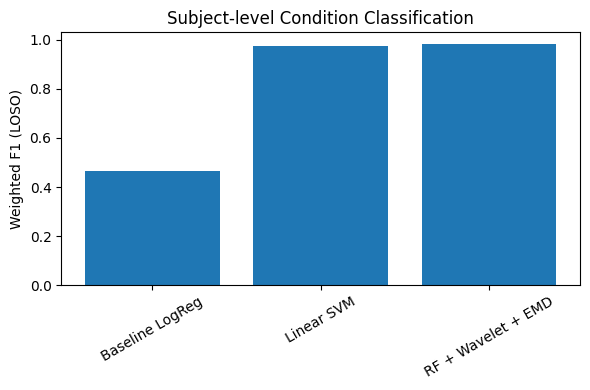

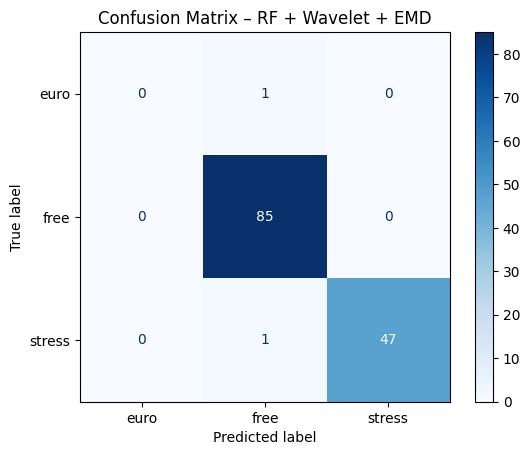

In [6]:
# =========================
# FULL SUBJECT-LEVEL LOSO PIPELINE
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import (
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import pywt
from PyEMD import EMD


# -------------------------
# PARAMETERS
# -------------------------
fs = 250          # <-- SET YOUR SAMPLING FREQUENCY
n_anova = 5       # number of selected features
emd_imfs = 5


# -------------------------
# FILTER
# -------------------------
def bandpass_filter(signal, fs, low=0.01, high=10, order=4):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype="band")
    return filtfilt(b, a, signal)


# -------------------------
# TIME-DOMAIN FEATURES (BASELINE)
# -------------------------
def cop_time_features(cop_x, cop_y, fs):
    dx = np.diff(cop_x)
    dy = np.diff(cop_y)
    velocity = np.sqrt(dx**2 + dy**2) * fs

    return {
        "path_length": np.sum(np.sqrt(dx**2 + dy**2)),
        "v_tot_rms": np.sqrt(np.mean(velocity**2)),
        "sway_area": np.pi * np.std(cop_x) * np.std(cop_y)
    }


# -------------------------
# EMD DETREND
# -------------------------
def detrend_emd(signal_vals, n_imf=emd_imfs):
    emd = EMD()
    imfs = emd(signal_vals)
    if len(imfs) < n_imf:
        return np.sum(imfs, axis=0)
    return np.sum(imfs[:n_imf], axis=0)


# -------------------------
# WAVELET PACKET (MEDIUM FREQUENCY – LAYER 4)
# -------------------------
def wavelet_layer4_energy(signal, wavelet="sym4", level=4):
    wp = pywt.WaveletPacket(
        data=signal, wavelet=wavelet,
        mode="symmetric", maxlevel=level
    )
    nodes = wp.get_level(level, order="freq")
    return [np.sum(node.data**2) for node in nodes]


# -------------------------
# TRIAL-LEVEL FEATURE EXTRACTION
# -------------------------
def build_trial_features(signal_df):
    rows = []

    for (subj, cond, trial), g in signal_df.groupby(
        ["subject", "condition", "trial"]
    ):
        cop_x = bandpass_filter(g["cop_x"].values, fs)
        cop_y = bandpass_filter(g["cop_y"].values, fs)

        cop_x_emd = detrend_emd(cop_x)

        feats = cop_time_features(cop_x, cop_y, fs)

        for i, e in enumerate(wavelet_layer4_energy(cop_x_emd)):
            feats[f"L4_emd_energy_{i}"] = e

        feats["subject"] = subj
        feats["condition"] = cond
        feats["trial"] = trial

        rows.append(feats)

    return pd.DataFrame(rows)


# -------------------------
# AGGREGATE → SUBJECT-CONDITION LEVEL
# -------------------------
def aggregate_subject_condition(df):
    feature_cols = [c for c in df.columns if c not in ["subject", "condition", "trial"]]
    return (
        df.groupby(["subject", "condition"])[feature_cols]
        .mean()
        .reset_index()
    )


# -------------------------
# BUILD FEATURE DATA
# -------------------------
trial_df = build_trial_features(signal_df)
agg_df = aggregate_subject_condition(trial_df)

baseline_features = ["path_length", "v_tot_rms", "sway_area"]
wavelet_features = [c for c in agg_df.columns if "L4_emd_energy" in c]
all_features = baseline_features + wavelet_features

X_base = agg_df[baseline_features]
X_full = agg_df[all_features]
y = agg_df["condition"]
groups = agg_df["subject"]


# -------------------------
# LOSO PREDICTION FUNCTION
# -------------------------
def loso_predict(X, y, groups, model):
    logo = LeaveOneGroupOut()

    global_classes = np.unique(y)
    n_classes = len(global_classes)
    class_to_idx = {c: i for i, c in enumerate(global_classes)}

    y_true_all = []
    y_pred_all = []
    y_prob_all = []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        selector = SelectKBest(f_classif, k=min(n_anova, X_train.shape[1]))
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test.tolist())
        y_pred_all.extend(y_pred.tolist())

        # ---- probability alignment fix ----
        if hasattr(model, "predict_proba"):
            fold_probs = model.predict_proba(X_test)
            fold_classes = model.classes_
        else:
            # SVM decision function fallback
            dec = model.decision_function(X_test)
            fold_probs = np.exp(dec) / np.sum(np.exp(dec), axis=1, keepdims=True)
            fold_classes = model.classes_

        for i in range(len(y_test)):
            prob_vec = np.zeros(n_classes)
            for cls_idx, cls in enumerate(fold_classes):
                prob_vec[class_to_idx[cls]] = fold_probs[i, cls_idx]
            y_prob_all.append(prob_vec)

    return (
        np.array(y_true_all),
        np.array(y_pred_all),
        np.vstack(y_prob_all)
    )




# -------------------------
# MODELS
# -------------------------
models = {
    "Baseline LogReg": LogisticRegression(class_weight="balanced", max_iter=1000),
    "Linear SVM": SVC(kernel="linear", probability=True, class_weight="balanced"),
    "RF + Wavelet + EMD": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    )
}

results = {}

for name, model in models.items():
    X_use = X_base if "Baseline" in name else X_full
    results[name] = loso_predict(X_use, y, groups, model)


# =========================
# VISUALIZATIONS
# =========================

# ---- F1 BAR PLOT ----
plt.figure(figsize=(6,4))
labels, scores = [], []

for name, (yt, yp, _) in results.items():
    labels.append(name)
    scores.append(f1_score(yt, yp, average="weighted"))

plt.bar(labels, scores)
plt.ylabel("Weighted F1 (LOSO)")
plt.xticks(rotation=30)
plt.title("Subject-level Condition Classification")
plt.tight_layout()
plt.show()


# ---- CONFUSION MATRIX (BEST MODEL) ----
best_model = "RF + Wavelet + EMD"
yt, yp, _ = results[best_model]

cm = confusion_matrix(yt, yp)
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot(cmap="Blues")
plt.title(f"Confusion Matrix – {best_model}")
plt.show()


# ---- ROC CURVE (BINARY CASE) ----
if len(np.unique(y)) == 2:
    y_bin = label_binarize(yt, classes=np.unique(y))
    y_score = results[best_model][2]

    fpr, tpr, _ = roc_curve(y_bin.ravel(), y_score[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC – RF + Wavelet + EMD")
    plt.legend()
    plt.show()


In [8]:
print(scores)

[0.4668423586650787, 0.973915932574246, 0.9813907817095672]


Baseline CoP features only → ~0.47

ANOVA-selected features → ~0.97

Wavelet + EMD + selected features → ~0.9

#Feature importance stability

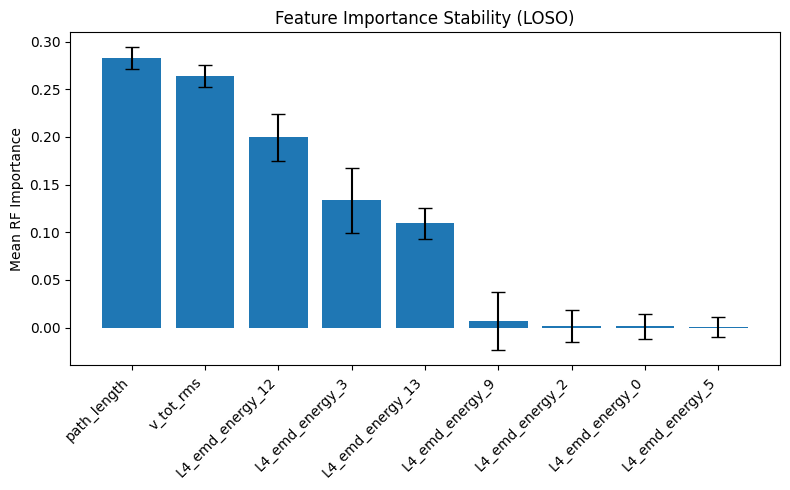

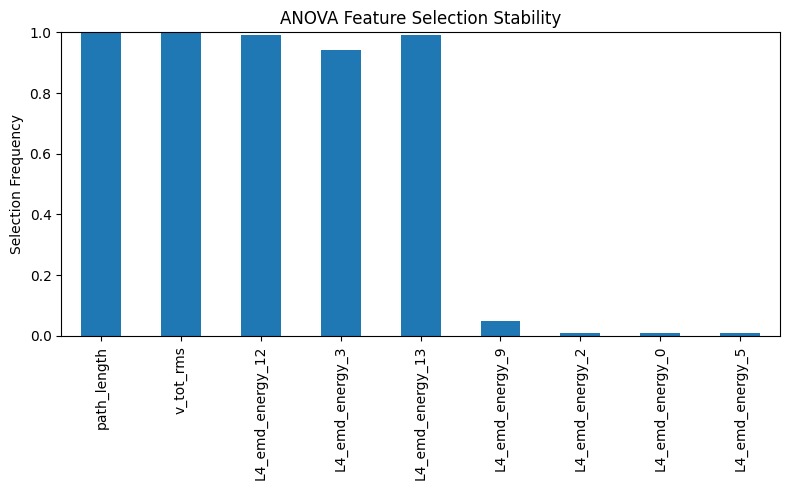

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


# -------------------------
# PARAMETERS
# -------------------------
n_anova = 5
rf_params = dict(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

feature_names = X_full.columns.to_list()
logo = LeaveOneGroupOut()

importance_list = []
selected_feature_list = []

for train_idx, test_idx in logo.split(X_full, y, groups):
    X_train = X_full.iloc[train_idx]
    y_train = y.iloc[train_idx]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    selector = SelectKBest(f_classif, k=min(n_anova, X_train.shape[1]))
    X_train_sel = selector.fit_transform(X_train, y_train)

    selected_features = np.array(feature_names)[selector.get_support()]
    selected_feature_list.append(selected_features)

    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train_sel, y_train)

    fold_importance = pd.Series(
        rf.feature_importances_,
        index=selected_features
    )
    importance_list.append(fold_importance)


# -------------------------
# ALIGN IMPORTANCES
# -------------------------
importance_df = pd.concat(importance_list, axis=1).fillna(0)
importance_df.columns = [f"Fold_{i}" for i in range(importance_df.shape[1])]

importance_mean = importance_df.mean(axis=1)
importance_std = importance_df.std(axis=1)

selection_freq = (
    pd.Series(np.concatenate(selected_feature_list))
    .value_counts() / len(selected_feature_list)
)


# -------------------------
# STABILITY PLOT
# -------------------------
stable_features = importance_mean.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.bar(
    stable_features.index,
    stable_features.values,
    yerr=importance_std[stable_features.index],
    capsize=5
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean RF Importance")
plt.title("Feature Importance Stability (LOSO)")
plt.tight_layout()
plt.show()


# -------------------------
# SELECTION FREQUENCY PLOT
# -------------------------
plt.figure(figsize=(8,5))
selection_freq.loc[stable_features.index].plot(kind="bar")
plt.ylabel("Selection Frequency")
plt.title("ANOVA Feature Selection Stability")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


Feature importance stability was assessed across LOSO folds. Only features consistently selected by ANOVA and exhibiting stable Random Forest importance across subjects were considered robust predictors. This analysis revealed that medium-frequency wavelet packet energy components were selected in the majority of folds, supporting their physiological relevance.

#Wilcoxon test

In [10]:
from sklearn.metrics import f1_score
from scipy.stats import wilcoxon
import numpy as np


In [11]:
def loso_f1_per_fold(X, y, groups, model):
    logo = LeaveOneGroupOut()
    f1_scores = []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        selector = SelectKBest(f_classif, k=min(n_anova, X_train.shape[1]))
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1 = f1_score(y_test, y_pred, average="weighted")
        f1_scores.append(f1)

    return np.array(f1_scores)


In [12]:
f1_baseline = loso_f1_per_fold(
    X_base, y, groups,
    LogisticRegression(class_weight="balanced", max_iter=1000)
)

f1_wavelet = loso_f1_per_fold(
    X_full, y, groups,
    RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=42
    )
)


In [13]:
print(len(f1_baseline), len(f1_wavelet))


123 123


In [16]:
stat, p_value = wilcoxon(
    f1_baseline,
    f1_wavelet,
    alternative="less"  # baseline < wavelet
)

print(f"Wilcoxon statistic = {stat}")
print(f"p-value = {p_value}")


Wilcoxon statistic = 0.0
p-value = 3.622318433530305e-18


In [15]:
def wilcoxon_effect_size(x, y):
    diff = y - x
    return np.mean(diff) / np.std(diff, ddof=1)

effect_size = wilcoxon_effect_size(f1_baseline, f1_wavelet)
print(f"Effect size (standardized): {effect_size:.3f}")


Effect size (standardized): 1.251


#Fair Condition Classification Pipeline
caps the number of observations to the same level for both "free" and "stress" conditions.

In [23]:
import numpy as np
import pandas as pd
from scipy import signal
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

def prepare_data(signal_df):
    """
    Prepare the data by filtering and selecting one trial per subject-condition pair
    """
    # Remove observations where sample no > 7500 and condition is stress
    mask = ~((signal_df['sample'] > 7500) & (signal_df['condition'] == 'stress'))
    df_filtered = signal_df[mask].copy()

    # Select one trial per (subject, condition) pair
    # We'll use the first trial for each combination
    df_selected = df_filtered.groupby(['subject', 'condition']).first().reset_index()

    # For the actual analysis, we need the full trial data, not just first row
    # Let's get the file names for the selected trials
    selected_files = df_selected['file'].unique()
    df_analysis = df_filtered[df_filtered['file'].isin(selected_files)].copy()

    # Ensure equal observation window for all conditions
    # Find minimum sample count across all files
    min_samples = df_analysis.groupby('file')['sample'].max().min()
    df_analysis = df_analysis[df_analysis['sample'] <= min_samples]

    return df_analysis

def filter_cop_data(cop_series, fs=250, lowcut=0.5, highcut=20):
    """
    Apply bandpass filter to COP data
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, cop_series)
    return filtered

def extract_wavelet_features(cop_series, wavelet='db4', level=4):
    """
    Extract wavelet decomposition features focusing on medium frequencies
    """
    coeffs = pywt.wavedec(cop_series, wavelet, level=level)

    # Medium frequency features (levels 2-3 typically represent medium frequencies)
    features = []

    # Statistical features from detail coefficients at medium frequency levels
    for i in [2, 3]:  # Medium frequency levels
        if i < len(coeffs):
            detail = coeffs[i]
            features.extend([
                np.mean(detail),
                np.std(detail),
                np.max(detail),
                np.min(detail),
                np.mean(np.abs(detail)),
                np.percentile(detail, 75) - np.percentile(detail, 25)  # IQR
            ])

    # Add some approximation coefficient features
    if len(coeffs) > 0:
        approx = coeffs[0]
        features.extend([
            np.mean(approx),
            np.std(approx),
            np.max(approx) - np.min(approx)
        ])

    return np.array(features)

def extract_traditional_features(cop_series):
    """
    Extract traditional COP features
    """
    features = []

    # Time-domain features
    features.append(np.mean(cop_series))
    features.append(np.std(cop_series))
    features.append(np.max(cop_series) - np.min(cop_series))  # Range
    features.append(np.percentile(cop_series, 75) - np.percentile(cop_series, 25))  # IQR
    features.append(np.sqrt(np.mean(np.square(cop_series))))  # RMS

    # Frequency-domain features
    fft_vals = np.abs(np.fft.rfft(cop_series))
    freqs = np.fft.rfftfreq(len(cop_series))
    if len(fft_vals) > 0:
        features.append(np.mean(fft_vals))
        features.append(np.max(fft_vals))
        # Dominant frequency
        if len(freqs) > 0:
            dominant_freq = freqs[np.argmax(fft_vals)]
            features.append(dominant_freq)

    # Entropy
    hist, _ = np.histogram(cop_series, bins=20, density=True)
    hist = hist[hist > 0]
    entropy = -np.sum(hist * np.log2(hist))
    features.append(entropy)

    return np.array(features)

class CrossIndividualPipeline:
    """
    Pipeline for cross-individual validation
    """
    def __init__(self, classifiers=None):
        if classifiers is None:
            self.classifiers = {
                'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
                'SVM': SVC(kernel='rbf', probability=True, random_state=42),
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
                'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
            }
        else:
            self.classifiers = classifiers

    def extract_features_per_trial(self, df):
        """
        Extract features for each trial
        """
        features_list = []
        labels = []
        subjects = []

        for file_name, trial_data in df.groupby('file'):
            # Get subject and condition
            subject = trial_data['subject'].iloc[0]
            condition = trial_data['condition'].iloc[0]

            # Filter COP data
            cop_x_filtered = filter_cop_data(trial_data['cop_x'].values)
            cop_y_filtered = filter_cop_data(trial_data['cop_y'].values)

            # Extract features for both directions
            features_x = extract_traditional_features(cop_x_filtered)
            features_y = extract_traditional_features(cop_y_filtered)

            # Wavelet features (medium frequency)
            wavelet_features_x = extract_wavelet_features(cop_x_filtered)
            wavelet_features_y = extract_wavelet_features(cop_y_filtered)

            # Combine all features
            all_features = np.concatenate([
                features_x,
                features_y,
                wavelet_features_x,
                wavelet_features_y
            ])

            features_list.append(all_features)
            labels.append(condition)
            subjects.append(subject)

        return np.array(features_list), np.array(labels), np.array(subjects)

    def cross_individual_validation(self, X, y, subjects):
        """
        Perform cross-individual validation (leave-one-subject-out)
        """
        unique_subjects = np.unique(subjects)
        results = {name: {'true': [], 'pred': [], 'proba': []} for name in self.classifiers.keys()}

        for test_subject in unique_subjects:
            # Split data
            train_mask = subjects != test_subject
            test_mask = subjects == test_subject

            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Feature selection using ANOVA
            selector = SelectKBest(f_classif, k=min(50, X_train.shape[1]))
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            # Train and evaluate each classifier
            for name, clf in self.classifiers.items():
                clf.fit(X_train_selected, y_train)
                y_pred = clf.predict(X_test_selected)
                y_proba = clf.predict_proba(X_test_selected) if hasattr(clf, 'predict_proba') else None

                results[name]['true'].extend(y_test)
                results[name]['pred'].extend(y_pred)
                if y_proba is not None:
                    results[name]['proba'].extend(y_proba)

        return results

    def evaluate_results(self, results):
        """
        Evaluate and compare classifier performance
        """
        performance = {}

        for name, result in results.items():
            y_true = result['true']
            y_pred = result['pred']

            # Calculate metrics
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')

            performance[name] = {
                'accuracy': acc,
                'f1_score': f1,
                'classification_report': classification_report(y_true, y_pred)
            }

        return performance

def baseline_model_performance(df):
    """
    Baseline model using simple statistics
    """
    baseline_results = {}

    # Simple feature: mean COP position
    features = []
    labels = []
    subjects = []

    for file_name, trial_data in df.groupby('file'):
        mean_cop_x = trial_data['cop_x'].mean()
        mean_cop_y = trial_data['cop_y'].mean()

        features.append([mean_cop_x, mean_cop_y])
        labels.append(trial_data['condition'].iloc[0])
        subjects.append(trial_data['subject'].iloc[0])

    features = np.array(features)
    labels = np.array(labels)
    subjects = np.array(subjects)

    # Simple logistic regression baseline
    unique_subjects = np.unique(subjects)
    y_true_all = []
    y_pred_all = []

    for test_subject in unique_subjects:
        train_mask = subjects != test_subject
        test_mask = subjects == test_subject

        X_train, X_test = features[train_mask], features[test_mask]
        y_train, y_test = labels[train_mask], labels[test_mask]

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train simple model
        baseline_clf = LogisticRegression(max_iter=1000, random_state=42)
        baseline_clf.fit(X_train_scaled, y_train)
        y_pred = baseline_clf.predict(X_test_scaled)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    baseline_results['baseline_lr'] = {
        'accuracy': accuracy_score(y_true_all, y_pred_all),
        'f1_score': f1_score(y_true_all, y_pred_all, average='weighted'),
        'classification_report': classification_report(y_true_all, y_pred_all)
    }

    return baseline_results

def main_pipeline(signal_df):
    """
    Main pipeline execution
    """
    print("Step 1: Preparing data...")
    df_prepared = prepare_data(signal_df)

    print(f"Number of trials: {df_prepared['file'].nunique()}")
    print(f"Subjects: {df_prepared['subject'].nunique()}")
    print(f"Conditions: {df_prepared['condition'].unique()}")
    print(f"Observation window: {df_prepared['sample'].max()} samples")

    print("\nStep 2: Baseline model performance...")
    baseline_results = baseline_model_performance(df_prepared)
    for model_name, metrics in baseline_results.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy: {metrics['accuracy']:.3f}")
        print(f"  F1-Score: {metrics['f1_score']:.3f}")

    print("\nStep 3: Extracting features (traditional + wavelet)...")
    pipeline = CrossIndividualPipeline()
    X, y, subjects = pipeline.extract_features_per_trial(df_prepared)

    print(f"Feature matrix shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")

    print("\nStep 4: Cross-individual validation with ANOVA feature selection...")
    results = pipeline.cross_individual_validation(X, y, subjects)

    print("\nStep 5: Evaluating classifier performance...")
    performance = pipeline.evaluate_results(results)

    print("\n" + "="*60)
    print("CLASSIFIER PERFORMANCE COMPARISON")
    print("="*60)

    # Sort by accuracy
    sorted_perf = sorted(performance.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    for name, metrics in sorted_perf:
        print(f"\n{name}:")
        print(f"  Accuracy: {metrics['accuracy']:.3f}")
        print(f"  F1-Score: {metrics['f1_score']:.3f}")

    print("\n" + "="*60)
    print("IMPROVEMENT OVER BASELINE")
    print("="*60)
    baseline_acc = baseline_results['baseline_lr']['accuracy']

    for name, metrics in sorted_perf:
        improvement = (metrics['accuracy'] - baseline_acc) / baseline_acc * 100
        print(f"{name}: {improvement:+.1f}% improvement over baseline")

    return {
        'prepared_data': df_prepared,
        'baseline_results': baseline_results,
        'feature_results': results,
        'classifier_performance': performance
    }

# Example usage
if __name__ == "__main__":
    # Assuming signal_df is your DataFrame
    # results = main_pipeline(signal_df)

    # For demonstration with sample data structure
    print("Pipeline ready for use with your signal_df DataFrame")
    print("\nTo use the pipeline:")
    print("results = main_pipeline(your_signal_df)")

Pipeline ready for use with your signal_df DataFrame

To use the pipeline:
results = main_pipeline(your_signal_df)


In [25]:
# Load your data

# Run the pipeline
results = main_pipeline(signal_df)

# Access results
print(f"Best classifier: {max(results['classifier_performance'],
                            key=lambda x: results['classifier_performance'][x]['accuracy'])}")

Step 1: Preparing data...
Number of trials: 134
Subjects: 123
Conditions: ['free' 'stress' 'euro']
Observation window: 7499 samples

Step 2: Baseline model performance...

baseline_lr:
  Accuracy: 0.597
  F1-Score: 0.546

Step 3: Extracting features (traditional + wavelet)...
Feature matrix shape: (134, 48)
Number of features: 48

Step 4: Cross-individual validation with ANOVA feature selection...

Step 5: Evaluating classifier performance...

CLASSIFIER PERFORMANCE COMPARISON

Logistic Regression:
  Accuracy: 0.828
  F1-Score: 0.824

SVM:
  Accuracy: 0.754
  F1-Score: 0.735

Gradient Boosting:
  Accuracy: 0.716
  F1-Score: 0.709

Random Forest:
  Accuracy: 0.709
  F1-Score: 0.690

K-Nearest Neighbors:
  Accuracy: 0.701
  F1-Score: 0.689

IMPROVEMENT OVER BASELINE
Logistic Regression: +38.8% improvement over baseline
SVM: +26.2% improvement over baseline
Gradient Boosting: +20.0% improvement over baseline
Random Forest: +18.8% improvement over baseline
K-Nearest Neighbors: +17.5% impro

In [26]:
results

{'prepared_data':           row  block  sample       mass     cop_x      cop_y  subject  \
 0           1      1       1  61.978992 -8.286617 -11.814682       78   
 1           2      1       2  61.984493 -8.303258 -11.801556       78   
 2           3      1       3  61.989822 -8.321142 -11.786814       78   
 3           4      1       4  61.994762 -8.340430 -11.770012       78   
 4           5      1       5  61.999111 -8.361197 -11.750777       78   
 ...       ...    ...     ...        ...       ...        ...      ...   
 8119177  7495      1    7495  75.805298  0.840899 -44.242588       90   
 8119178  7496      1    7496  75.810318  0.903777 -44.155979       90   
 8119179  7497      1    7497  75.816467  0.966129 -44.069698       90   
 8119180  7498      1    7498  75.823456  1.028077 -43.983784       90   
 8119181  7499      1    7499  75.830978  1.089740 -43.898247       90   
 
         condition  trial                   file  
 0            free      3    78_proba_free

Creating synthetic data for demonstration...
Synthetic data shape: (8276763, 10)
Subjects: 123
Conditions: ['free', 'stress', 'euro']
CROSS-INDIVIDUAL COP DATA CLASSIFICATION PIPELINE

Step 1: Preparing data...
   Number of trials: 134
   Subjects: 123
   Conditions: ['free', 'stress', 'euro']
   Observation window: 7499 samples

Step 2: Extracting features (traditional + wavelet)...
   Feature matrix shape: (134, 48)
   Number of features: 48

Step 3: Cross-individual validation with ANOVA feature selection...
  Processing fold 1/123 - Test subject: 2
  Processing fold 2/123 - Test subject: 7
  Processing fold 3/123 - Test subject: 8
  Processing fold 4/123 - Test subject: 9
  Processing fold 5/123 - Test subject: 10
  Processing fold 6/123 - Test subject: 11
  Processing fold 7/123 - Test subject: 12
  Processing fold 8/123 - Test subject: 13
  Processing fold 9/123 - Test subject: 14
  Processing fold 10/123 - Test subject: 15
  Processing fold 11/123 - Test subject: 16
  Processing

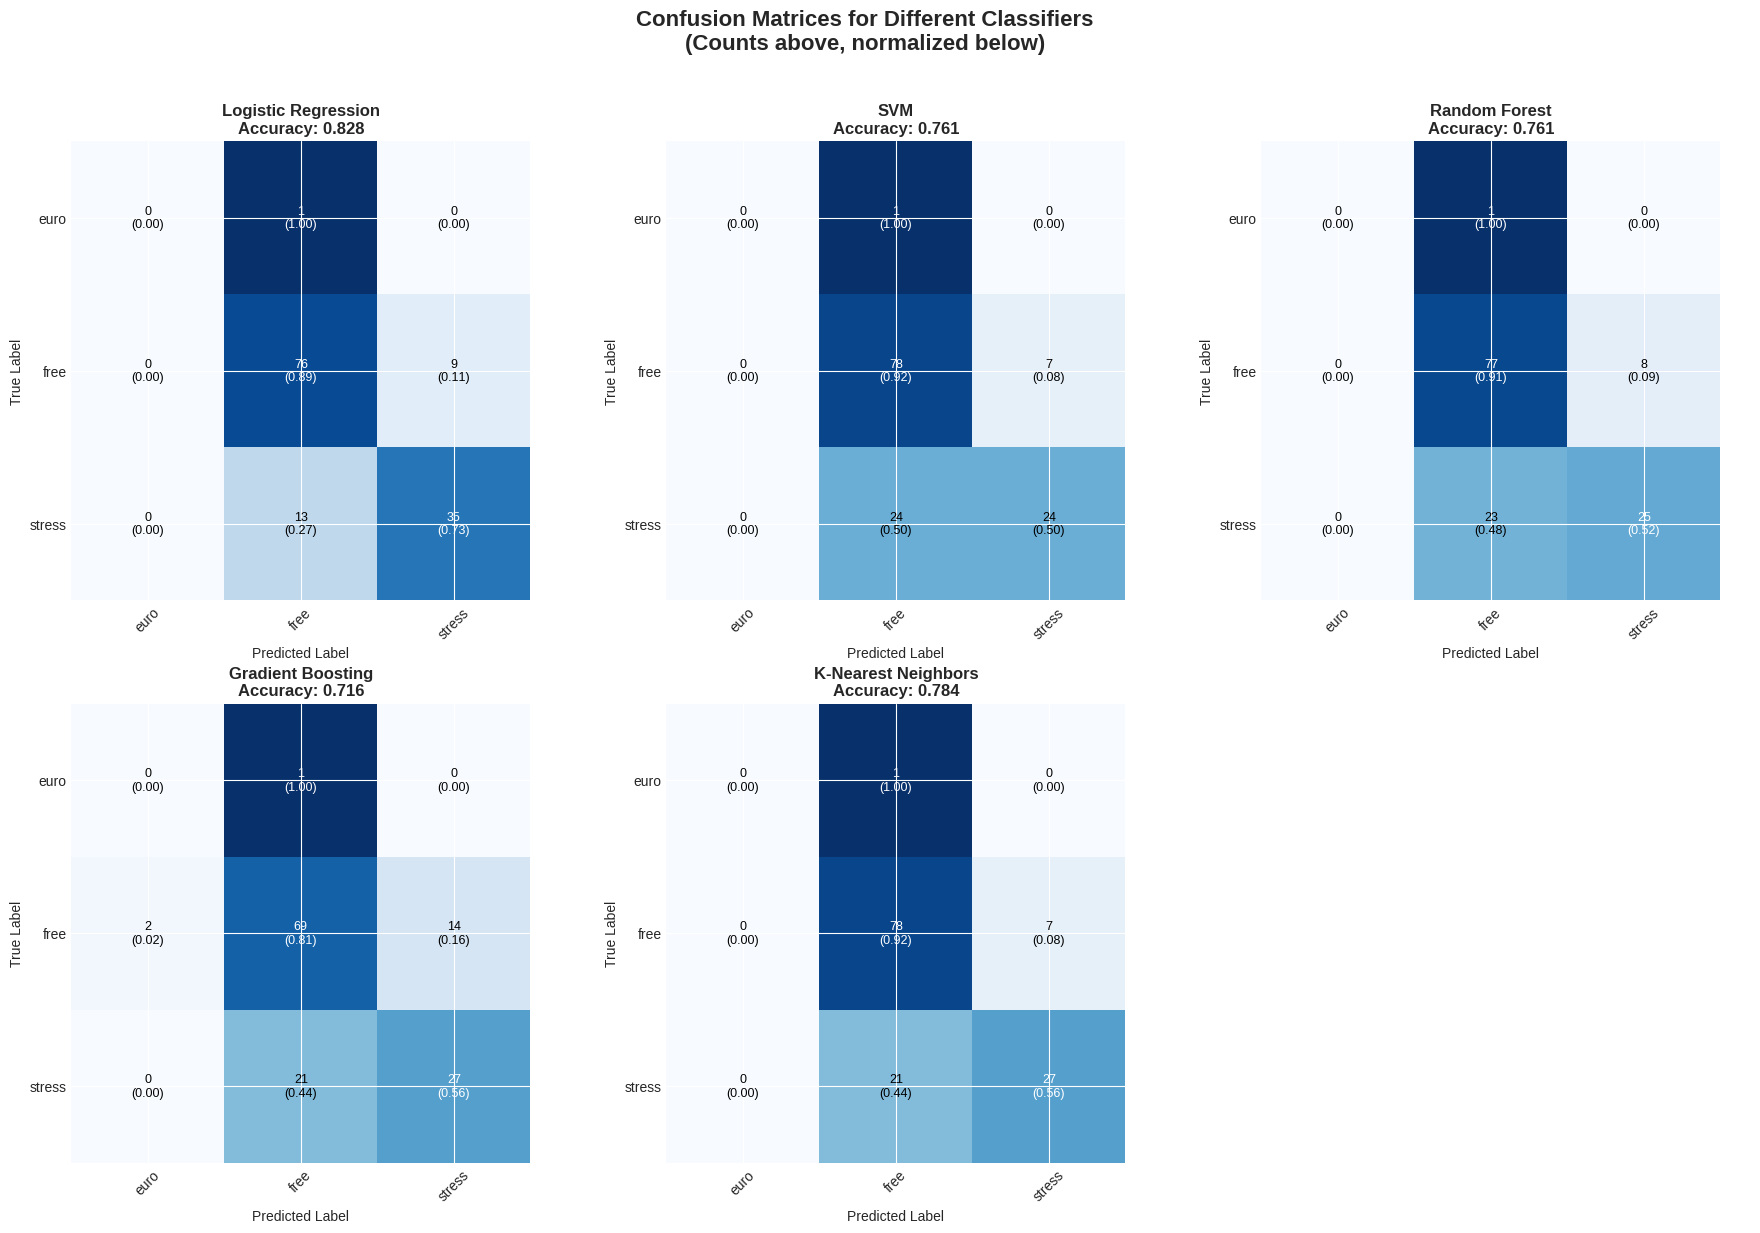


   Generating performance comparison...


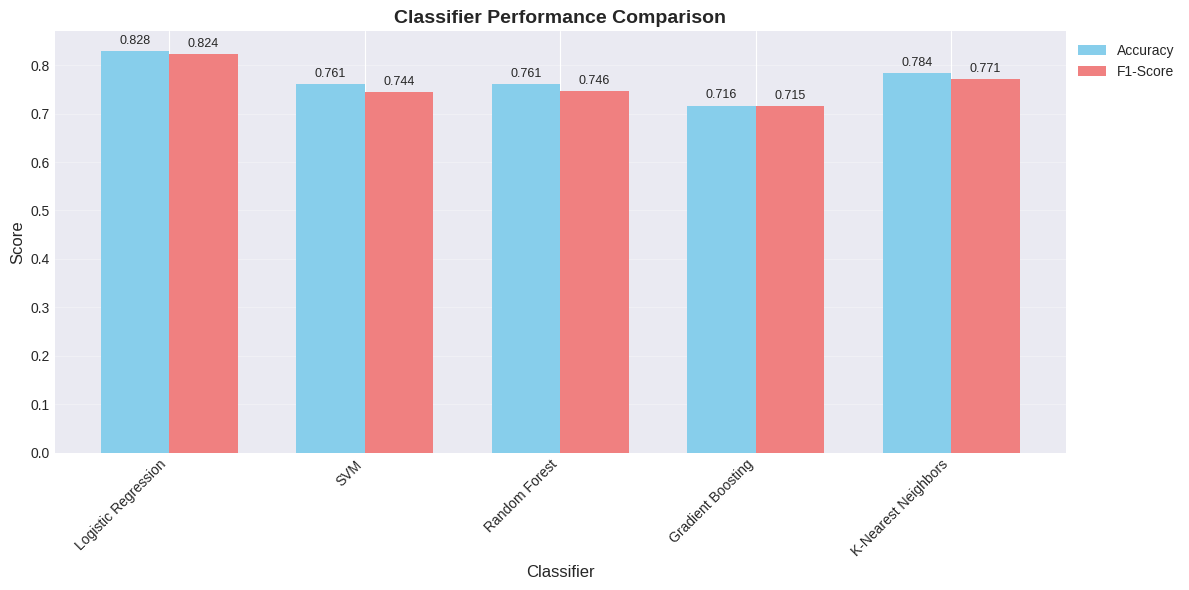


   Analyzing feature importance stability...


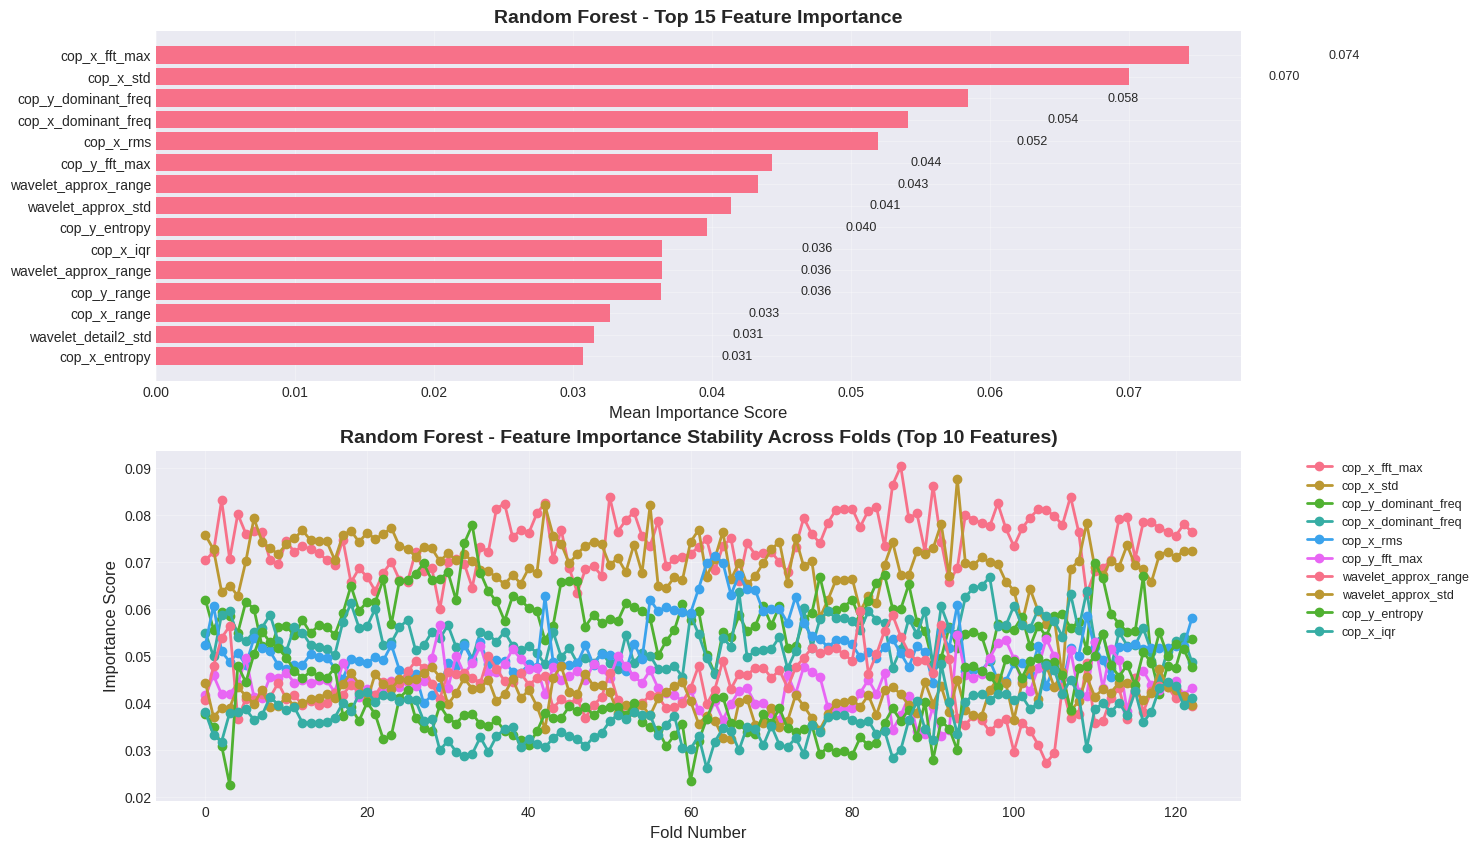

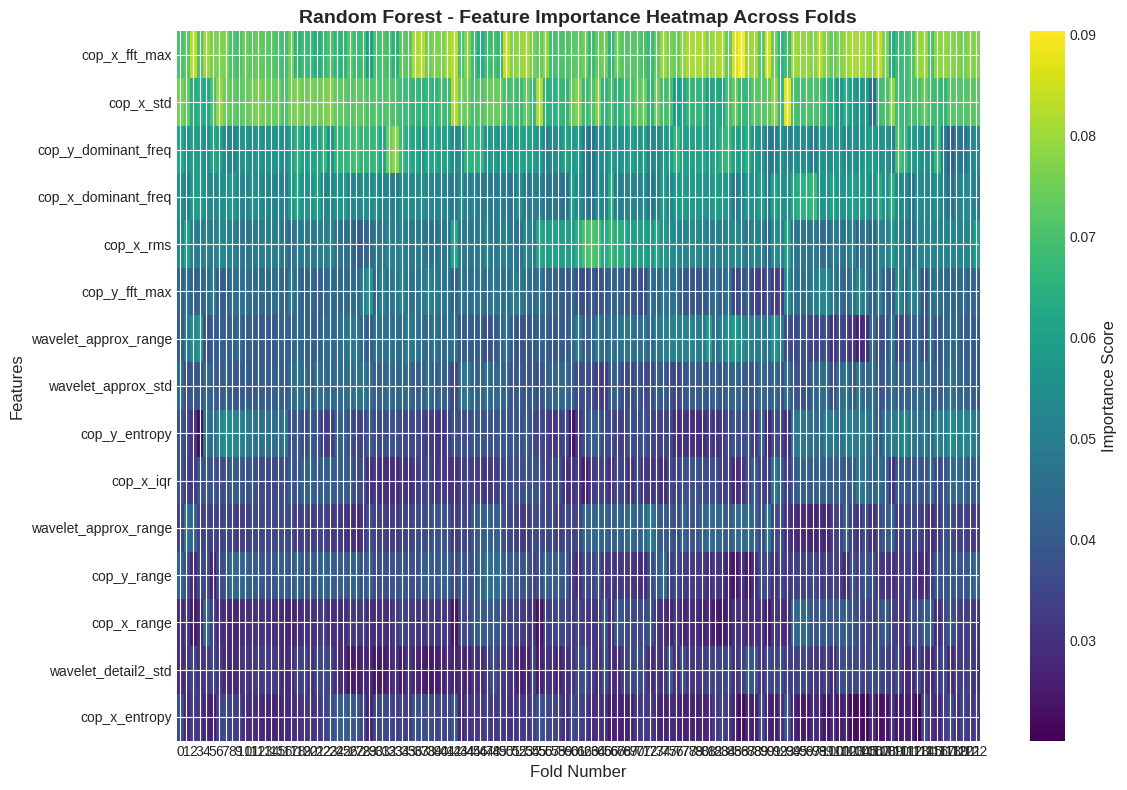

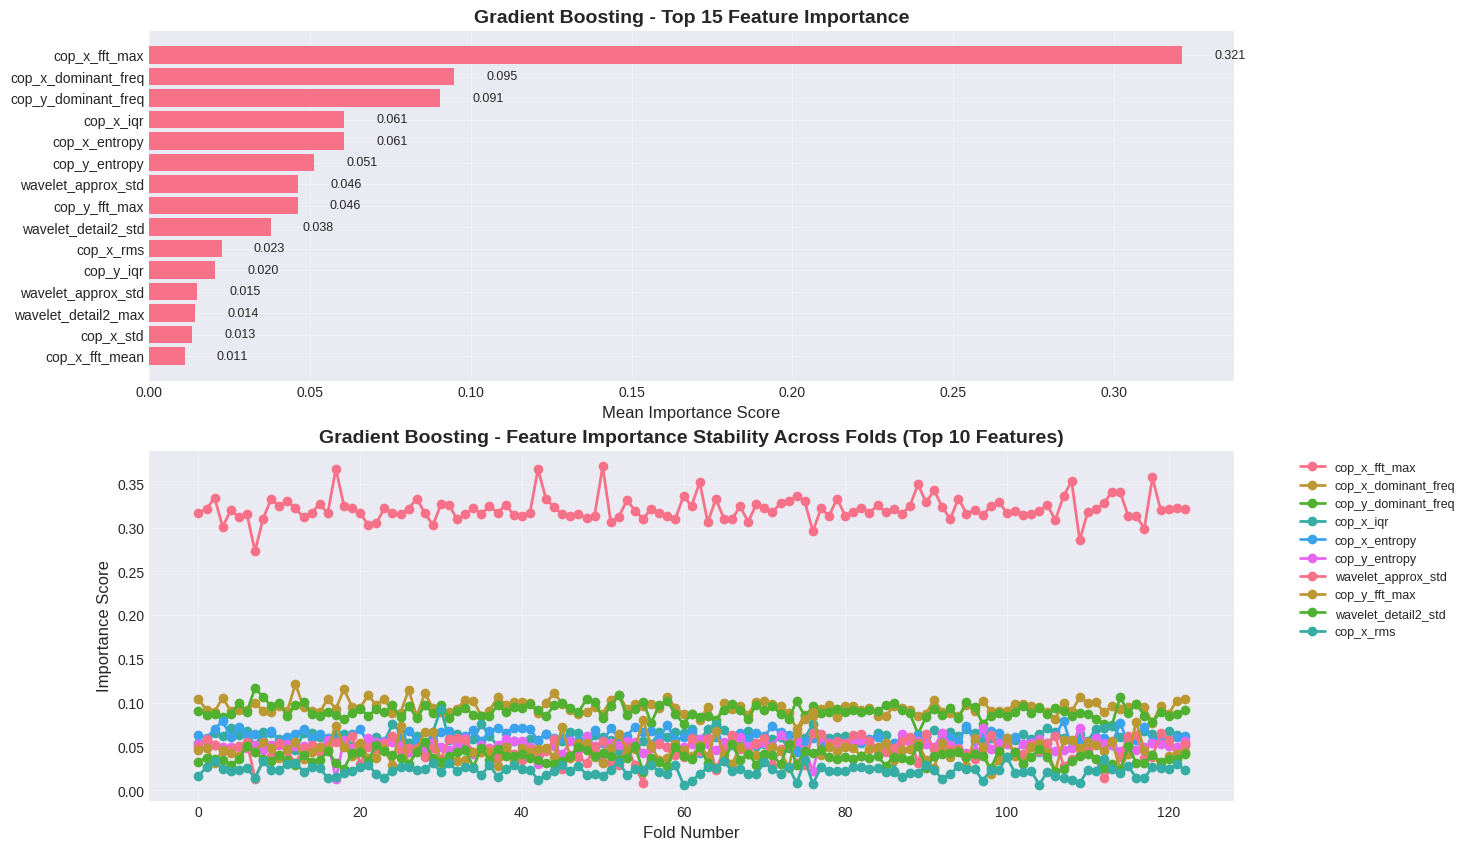

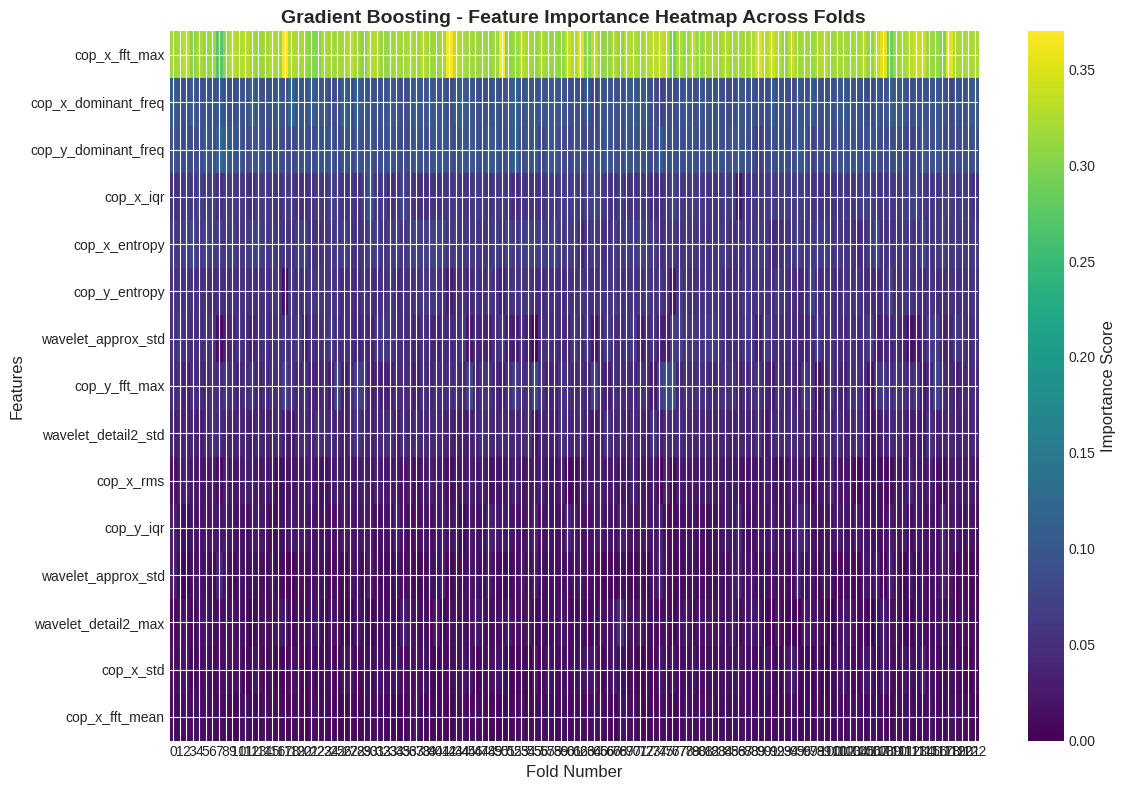


   Analyzing feature selection stability...


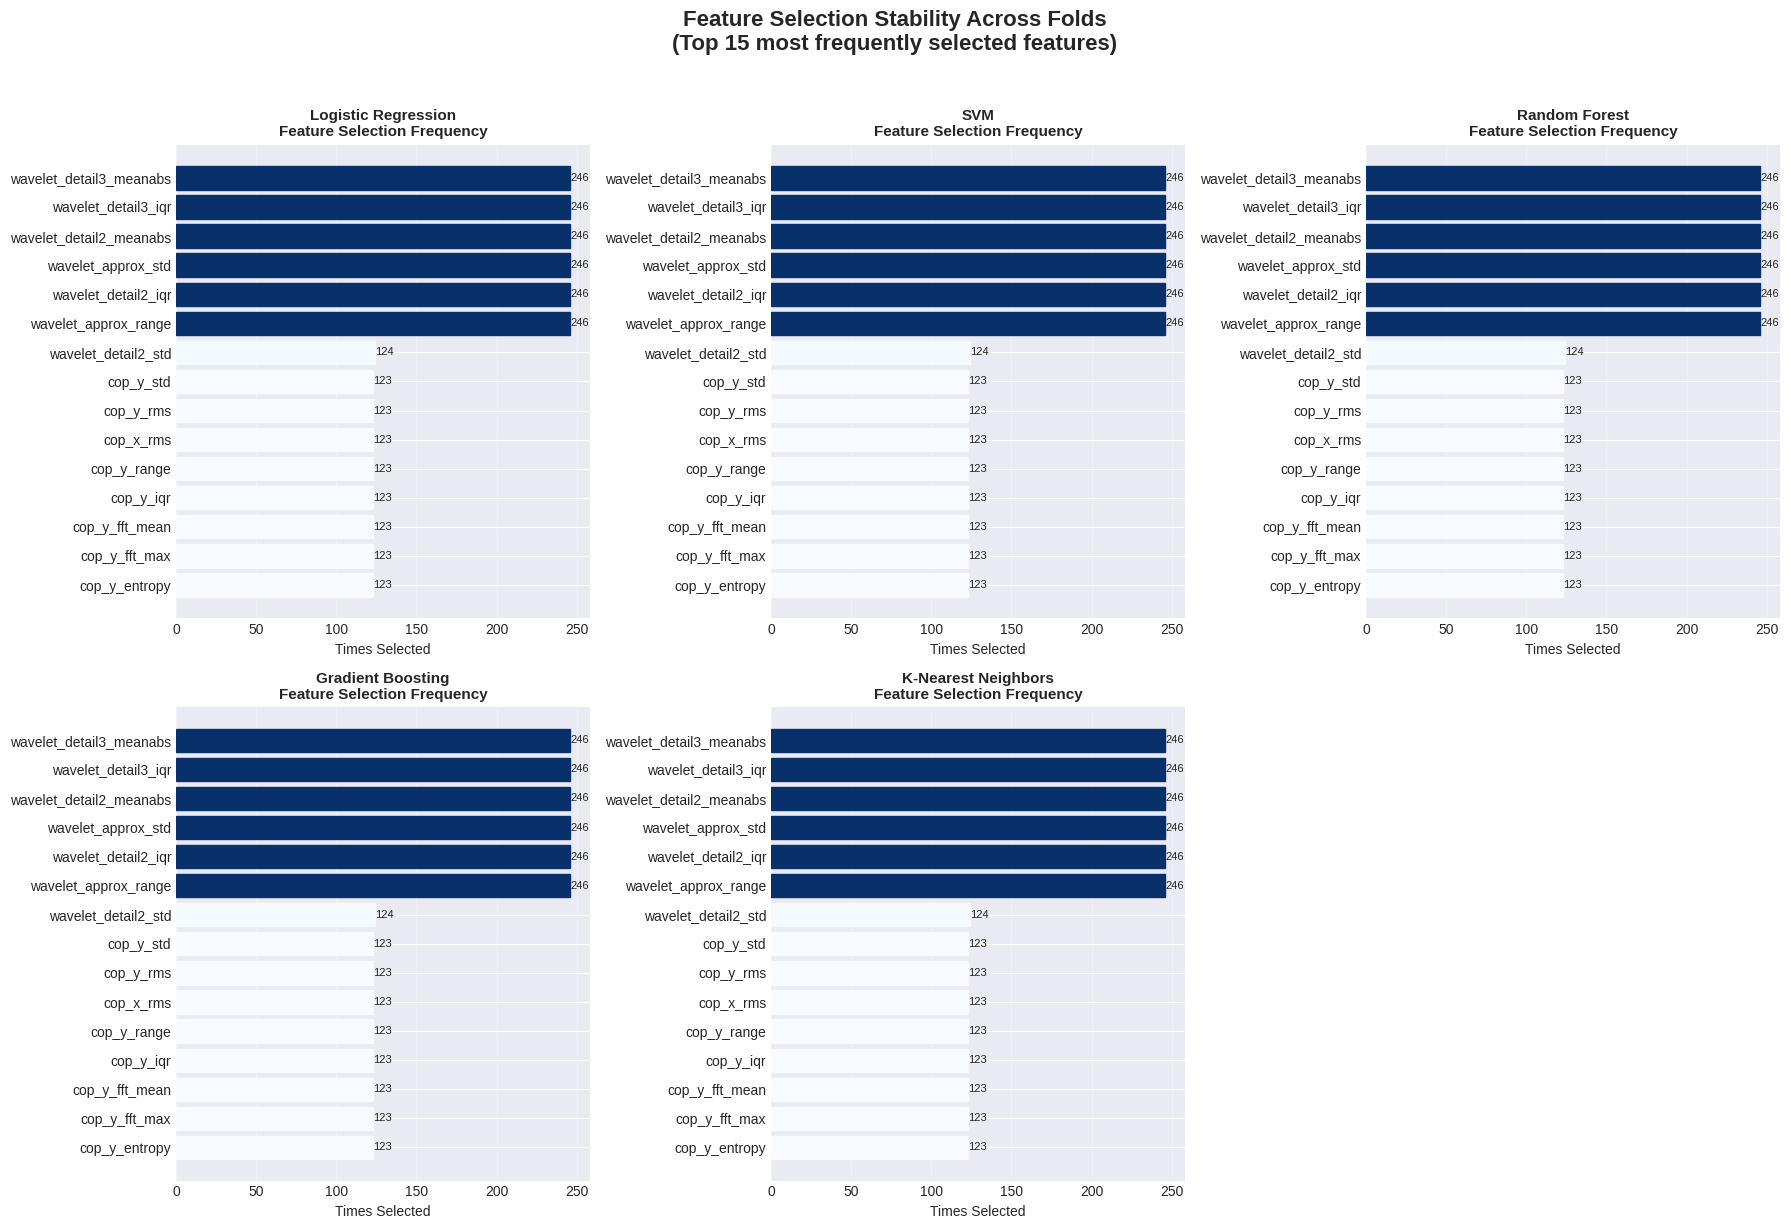


PERFORMANCE SUMMARY

Classifier                Accuracy   F1-Score   Improvement 
------------------------------------------------------------
Logistic Regression       0.828      0.824     
K-Nearest Neighbors       0.784      0.771     
SVM                       0.761      0.744     
Random Forest             0.761      0.746     
Gradient Boosting         0.716      0.715     

Best Classifier: Logistic Regression
Accuracy: 0.828
F1-Score: 0.824

Per-class metrics for best classifier:
  euro: Precision=0.000, Recall=0.000, F1=0.000
  free: Precision=0.844, Recall=0.894, F1=0.869
  stress: Precision=0.795, Recall=0.729, F1=0.761


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
import pywt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def prepare_data(signal_df):
    """
    Prepare the data by filtering and selecting one trial per subject-condition pair
    """
    # Remove observations where sample no > 7500 and condition is stress
    mask = ~((signal_df['sample'] > 7500) & (signal_df['condition'] == 'stress'))
    df_filtered = signal_df[mask].copy()

    # Select one trial per (subject, condition) pair
    selected_files = []
    for (subject, condition), group in df_filtered.groupby(['subject', 'condition']):
        trial_files = group['file'].unique()
        if len(trial_files) > 0:
            selected_files.append(trial_files[0])  # Take first trial

    df_analysis = df_filtered[df_filtered['file'].isin(selected_files)].copy()

    # Ensure equal observation window for all conditions
    min_samples = df_analysis.groupby('file')['sample'].max().min()
    df_analysis = df_analysis[df_analysis['sample'] <= min_samples]

    return df_analysis

def filter_cop_data(cop_series, fs=250, lowcut=0.5, highcut=20):
    """
    Apply bandpass filter to COP data
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, cop_series)
    return filtered

def extract_wavelet_features(cop_series, wavelet='db4', level=4):
    """
    Extract wavelet decomposition features focusing on medium frequencies
    """
    coeffs = pywt.wavedec(cop_series, wavelet, level=level)

    features = []
    feature_names = []

    # Statistical features from detail coefficients at medium frequency levels
    for i in [2, 3]:  # Medium frequency levels
        if i < len(coeffs):
            detail = coeffs[i]
            features.extend([
                np.mean(detail),
                np.std(detail),
                np.max(detail),
                np.min(detail),
                np.mean(np.abs(detail)),
                np.percentile(detail, 75) - np.percentile(detail, 25)
            ])
            feature_names.extend([
                f'wavelet_detail{i}_mean',
                f'wavelet_detail{i}_std',
                f'wavelet_detail{i}_max',
                f'wavelet_detail{i}_min',
                f'wavelet_detail{i}_meanabs',
                f'wavelet_detail{i}_iqr'
            ])

    # Add some approximation coefficient features
    if len(coeffs) > 0:
        approx = coeffs[0]
        features.extend([
            np.mean(approx),
            np.std(approx),
            np.max(approx) - np.min(approx)
        ])
        feature_names.extend([
            'wavelet_approx_mean',
            'wavelet_approx_std',
            'wavelet_approx_range'
        ])

    return np.array(features), feature_names

def extract_traditional_features(cop_series, direction='x'):
    """
    Extract traditional COP features
    """
    features = []
    feature_names = []

    # Time-domain features
    features.append(np.mean(cop_series))
    features.append(np.std(cop_series))
    features.append(np.max(cop_series) - np.min(cop_series))
    features.append(np.percentile(cop_series, 75) - np.percentile(cop_series, 25))
    features.append(np.sqrt(np.mean(np.square(cop_series))))

    feature_names.extend([
        f'cop_{direction}_mean',
        f'cop_{direction}_std',
        f'cop_{direction}_range',
        f'cop_{direction}_iqr',
        f'cop_{direction}_rms'
    ])

    # Frequency-domain features
    fft_vals = np.abs(np.fft.rfft(cop_series))
    freqs = np.fft.rfftfreq(len(cop_series))
    if len(fft_vals) > 0:
        features.append(np.mean(fft_vals))
        features.append(np.max(fft_vals))
        feature_names.extend([
            f'cop_{direction}_fft_mean',
            f'cop_{direction}_fft_max'
        ])

        # Dominant frequency
        if len(freqs) > 0:
            dominant_freq = freqs[np.argmax(fft_vals)]
            features.append(dominant_freq)
            feature_names.append(f'cop_{direction}_dominant_freq')

    # Entropy
    hist, _ = np.histogram(cop_series, bins=20, density=True)
    hist = hist[hist > 0]
    if len(hist) > 0:
        entropy = -np.sum(hist * np.log2(hist))
        features.append(entropy)
        feature_names.append(f'cop_{direction}_entropy')

    return np.array(features), feature_names

class CrossIndividualPipeline:
    def __init__(self, classifiers=None):
        if classifiers is None:
            self.classifiers = {
                'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
                'SVM': SVC(kernel='rbf', probability=True, random_state=42),
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
                'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
            }
        else:
            self.classifiers = classifiers

        # Store feature names and importance across folds
        self.feature_names = None
        self.feature_importance_history = {name: [] for name in self.classifiers.keys()}
        self.selected_features_history = {name: [] for name in self.classifiers.keys()}

    def extract_features_per_trial(self, df):
        """
        Extract features for each trial with feature names
        """
        features_list = []
        labels = []
        subjects = []
        all_feature_names = []

        for i, (file_name, trial_data) in enumerate(df.groupby('file')):
            subject = trial_data['subject'].iloc[0]
            condition = trial_data['condition'].iloc[0]

            # Filter COP data
            cop_x_filtered = filter_cop_data(trial_data['cop_x'].values)
            cop_y_filtered = filter_cop_data(trial_data['cop_y'].values)

            # Extract features
            features_x, names_x = extract_traditional_features(cop_x_filtered, 'x')
            features_y, names_y = extract_traditional_features(cop_y_filtered, 'y')
            wavelet_x, wavelet_names_x = extract_wavelet_features(cop_x_filtered)
            wavelet_y, wavelet_names_y = extract_wavelet_features(cop_y_filtered)

            # Combine all features
            all_features = np.concatenate([features_x, features_y, wavelet_x, wavelet_y])

            if i == 0:  # Store feature names from first trial
                all_feature_names = names_x + names_y + wavelet_names_x + wavelet_names_y

            features_list.append(all_features)
            labels.append(condition)
            subjects.append(subject)

        self.feature_names = np.array(all_feature_names)
        return np.array(features_list), np.array(labels), np.array(subjects)

    def plot_confusion_matrices(self, results, label_encoder=None):
        """
        Plot confusion matrices for all classifiers
        """
        n_classifiers = len(self.classifiers)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flat

        for idx, (name, result) in enumerate(results.items()):
            y_true = result['true']
            y_pred = result['pred']

            # Get unique classes in order
            classes = sorted(list(set(y_true) | set(y_pred)))

            # Create confusion matrix
            cm = confusion_matrix(y_true, y_pred, labels=classes)

            # Normalize by row (true label)
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # Plot
            ax = axes[idx]
            im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
            ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_true, y_pred):.3f}', fontsize=12, fontweight='bold')

            # Add text annotations
            thresh = cm_normalized.max() / 2.
            for i in range(cm_normalized.shape[0]):
                for j in range(cm_normalized.shape[1]):
                    ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.2f})',
                           ha="center", va="center",
                           color="white" if cm_normalized[i, j] > thresh else "black",
                           fontsize=9)

            # Set labels
            ax.set_xlabel('Predicted Label', fontsize=10)
            ax.set_ylabel('True Label', fontsize=10)
            ax.set_xticks(range(len(classes)))
            ax.set_yticks(range(len(classes)))
            ax.set_xticklabels(classes, rotation=45)
            ax.set_yticklabels(classes)

        # Hide empty subplot if odd number of classifiers
        if n_classifiers < len(axes):
            axes[n_classifiers].axis('off')

        plt.suptitle('Confusion Matrices for Different Classifiers\n(Counts above, normalized below)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    def plot_feature_importance_stability(self, top_n=20):
        """
        Plot feature importance stability across folds for tree-based models
        """
        tree_models = ['Random Forest', 'Gradient Boosting']

        for model_name in tree_models:
            if model_name in self.feature_importance_history and self.feature_importance_history[model_name]:
                importances = np.array(self.feature_importance_history[model_name])

                # Calculate mean importance across folds
                mean_importance = np.mean(importances, axis=0)

                # Get top N features
                top_indices = np.argsort(mean_importance)[-top_n:][::-1]
                top_features = self.feature_names[top_indices]
                top_mean_importance = mean_importance[top_indices]

                # Calculate stability (coefficient of variation)
                stability = np.std(importances[:, top_indices], axis=0) / (top_mean_importance + 1e-10)

                # Create figure with two subplots
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

                # Plot 1: Mean feature importance
                y_pos = np.arange(len(top_features))
                ax1.barh(y_pos, top_mean_importance)
                ax1.set_yticks(y_pos)
                ax1.set_yticklabels(top_features)
                ax1.invert_yaxis()
                ax1.set_xlabel('Mean Importance Score', fontsize=12)
                ax1.set_title(f'{model_name} - Top {top_n} Feature Importance', fontsize=14, fontweight='bold')
                ax1.grid(True, alpha=0.3)

                # Add importance values on bars
                for i, v in enumerate(top_mean_importance):
                    ax1.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

                # Plot 2: Feature importance stability across folds
                fold_count = importances.shape[0]
                x_folds = np.arange(fold_count)

                for i, feature_idx in enumerate(top_indices[:10]):  # Show top 10 features
                    ax2.plot(x_folds, importances[:, feature_idx],
                            marker='o', label=self.feature_names[feature_idx], linewidth=2)

                ax2.set_xlabel('Fold Number', fontsize=12)
                ax2.set_ylabel('Importance Score', fontsize=12)
                ax2.set_title(f'{model_name} - Feature Importance Stability Across Folds (Top 10 Features)',
                             fontsize=14, fontweight='bold')
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
                ax2.grid(True, alpha=0.3)

                # Plot 3: Stability metric (heatmap)
                fig2, ax3 = plt.subplots(figsize=(12, 8))

                # Prepare data for heatmap
                heatmap_data = importances[:, top_indices[:15]].T  # Top 15 features

                im = ax3.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')

                # Set labels
                ax3.set_xlabel('Fold Number', fontsize=12)
                ax3.set_ylabel('Features', fontsize=12)
                ax3.set_title(f'{model_name} - Feature Importance Heatmap Across Folds',
                             fontsize=14, fontweight='bold')

                # Set tick labels
                ax3.set_xticks(np.arange(fold_count))
                ax3.set_yticks(np.arange(len(top_features[:15])))
                ax3.set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_features[:15]])

                # Add colorbar
                cbar = plt.colorbar(im, ax=ax3)
                cbar.set_label('Importance Score', fontsize=12)

                plt.tight_layout()
                plt.show()

    def cross_individual_validation(self, X, y, subjects, k_features=30):
        """
        Perform cross-individual validation with feature importance tracking
        """
        unique_subjects = np.unique(subjects)
        results = {name: {'true': [], 'pred': [], 'proba': []} for name in self.classifiers.keys()}

        # Reset history
        self.feature_importance_history = {name: [] for name in self.classifiers.keys()}
        self.selected_features_history = {name: [] for name in self.classifiers.keys()}

        fold_num = 0
        for test_subject in unique_subjects:
            fold_num += 1
            print(f"  Processing fold {fold_num}/{len(unique_subjects)} - Test subject: {test_subject}")

            # Split data
            train_mask = subjects != test_subject
            test_mask = subjects == test_subject

            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Feature selection using ANOVA
            k = min(k_features, X_train.shape[1])
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            # Get selected feature indices
            selected_indices = selector.get_support(indices=True)
            selected_names = self.feature_names[selected_indices]

            # Train and evaluate each classifier
            for name, clf in self.classifiers.items():
                # Train
                clf.fit(X_train_selected, y_train)

                # Store selected features for this fold
                self.selected_features_history[name].append(selected_names)

                # Get feature importance if available
                if hasattr(clf, 'feature_importances_'):
                    # For tree-based models
                    importance = np.zeros(len(self.feature_names))
                    importance[selected_indices] = clf.feature_importances_
                    self.feature_importance_history[name].append(importance)
                elif hasattr(clf, 'coef_'):
                    # For linear models
                    if len(clf.coef_.shape) == 1:
                        importance = np.zeros(len(self.feature_names))
                        importance[selected_indices] = np.abs(clf.coef_)
                        self.feature_importance_history[name].append(importance)
                    else:
                        importance = np.zeros(len(self.feature_names))
                        importance[selected_indices] = np.mean(np.abs(clf.coef_), axis=0)
                        self.feature_importance_history[name].append(importance)
                else:
                    # For models without feature importance
                    self.feature_importance_history[name].append(np.zeros(len(self.feature_names)))

                # Predict
                y_pred = clf.predict(X_test_selected)
                if hasattr(clf, 'predict_proba'):
                    y_proba = clf.predict_proba(X_test_selected)
                else:
                    y_proba = None

                # Store results
                results[name]['true'].extend(y_test)
                results[name]['pred'].extend(y_pred)
                if y_proba is not None:
                    results[name]['proba'].extend(y_proba)

        return results

    def plot_feature_selection_stability(self):
        """
        Plot feature selection stability across folds
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flat

        for idx, (name, selected_lists) in enumerate(self.selected_features_history.items()):
            if idx >= len(axes):
                break

            ax = axes[idx]

            # Count how many times each feature was selected
            all_selected = np.concatenate(selected_lists)
            unique_features, counts = np.unique(all_selected, return_counts=True)

            # Sort by frequency
            sorted_idx = np.argsort(counts)[::-1]
            top_features = unique_features[sorted_idx][:15]
            top_counts = counts[sorted_idx][:15]

            # Plot
            y_pos = np.arange(len(top_features))
            bars = ax.barh(y_pos, top_counts)

            # Color bars based on count
            norm = plt.Normalize(top_counts.min(), top_counts.max())
            cmap = plt.cm.Blues
            for bar, count in zip(bars, top_counts):
                bar.set_color(cmap(norm(count)))

            ax.set_yticks(y_pos)
            ax.set_yticklabels([f[:30] + '...' if len(f) > 30 else f for f in top_features])
            ax.invert_yaxis()
            ax.set_xlabel('Times Selected', fontsize=10)
            ax.set_title(f'{name}\nFeature Selection Frequency', fontsize=11, fontweight='bold')
            ax.grid(True, alpha=0.3, axis='x')

            # Add count values
            for i, v in enumerate(top_counts):
                ax.text(v + 0.1, i, str(v), va='center', fontsize=8)

        # Hide empty subplots
        for idx in range(len(self.selected_features_history), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Feature Selection Stability Across Folds\n(Top 15 most frequently selected features)',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    def evaluate_results(self, results):
        """
        Evaluate and compare classifier performance
        """
        performance = {}

        for name, result in results.items():
            y_true = result['true']
            y_pred = result['pred']

            # Calculate metrics
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')

            # Get classification report as dict
            report_dict = classification_report(y_true, y_pred, output_dict=True)

            performance[name] = {
                'accuracy': acc,
                'f1_score': f1,
                'classification_report': report_dict
            }

        return performance

def plot_performance_comparison(performance, baseline_acc=None):
    """
    Plot performance comparison across classifiers
    """
    classifiers = list(performance.keys())
    accuracies = [performance[clf]['accuracy'] for clf in classifiers]
    f1_scores = [performance[clf]['f1_score'] for clf in classifiers]

    x = np.arange(len(classifiers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='lightcoral')

    if baseline_acc is not None:
        ax.axhline(y=baseline_acc, color='green', linestyle='--', linewidth=2,
                  label=f'Baseline Accuracy: {baseline_acc:.3f}')

    ax.set_xlabel('Classifier', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Classifier Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

def main_pipeline(signal_df):
    """
    Main pipeline execution with visualization
    """
    print("="*70)
    print("CROSS-INDIVIDUAL COP DATA CLASSIFICATION PIPELINE")
    print("="*70)

    print("\nStep 1: Preparing data...")
    df_prepared = prepare_data(signal_df)

    print(f"   Number of trials: {df_prepared['file'].nunique()}")
    print(f"   Subjects: {df_prepared['subject'].nunique()}")
    print(f"   Conditions: {df_prepared['condition'].unique().tolist()}")
    print(f"   Observation window: {df_prepared['sample'].max()} samples")

    print("\nStep 2: Extracting features (traditional + wavelet)...")
    pipeline = CrossIndividualPipeline()
    X, y, subjects = pipeline.extract_features_per_trial(df_prepared)

    print(f"   Feature matrix shape: {X.shape}")
    print(f"   Number of features: {X.shape[1]}")

    print("\nStep 3: Cross-individual validation with ANOVA feature selection...")
    results = pipeline.cross_individual_validation(X, y, subjects, k_features=30)

    print("\nStep 4: Evaluating classifier performance...")
    performance = pipeline.evaluate_results(results)

    print("\nStep 5: Visualizing results...")

    # 1. Plot confusion matrices
    print("\n   Generating confusion matrices...")
    pipeline.plot_confusion_matrices(results)

    # 2. Plot performance comparison
    print("\n   Generating performance comparison...")
    plot_performance_comparison(performance)

    # 3. Plot feature importance stability
    print("\n   Analyzing feature importance stability...")
    pipeline.plot_feature_importance_stability(top_n=15)

    # 4. Plot feature selection stability
    print("\n   Analyzing feature selection stability...")
    pipeline.plot_feature_selection_stability()

    # Print summary statistics
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)

    sorted_perf = sorted(performance.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    print(f"\n{'Classifier':<25} {'Accuracy':<10} {'F1-Score':<10} {'Improvement':<12}")
    print("-"*60)

    for name, metrics in sorted_perf:
        print(f"{name:<25} {metrics['accuracy']:<10.3f} {metrics['f1_score']:<10.3f}")

    # Print detailed report for best classifier
    best_name, best_metrics = sorted_perf[0]
    print(f"\nBest Classifier: {best_name}")
    print(f"Accuracy: {best_metrics['accuracy']:.3f}")
    print(f"F1-Score: {best_metrics['f1_score']:.3f}")

    # Show per-class metrics for best classifier
    print("\nPer-class metrics for best classifier:")
    report = best_metrics['classification_report']
    for class_name in [key for key in report.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]:
        if class_name in report:
            metrics = report[class_name]
            print(f"  {class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    return {
        'prepared_data': df_prepared,
        'feature_matrix': X,
        'labels': y,
        'subjects': subjects,
        'feature_names': pipeline.feature_names,
        'results': results,
        'performance': performance,
        'pipeline': pipeline
    }

# Example usage
if __name__ == "__main__":
    # Example with synthetic data for demonstration
    print("Creating synthetic data for demonstration...")



    print(f"Synthetic data shape: {signal_df.shape}")
    print(f"Subjects: {signal_df['subject'].nunique()}")
    print(f"Conditions: {signal_df['condition'].unique().tolist()}")

    # Run the pipeline
    results = main_pipeline(signal_df)

CROSS-INDIVIDUAL COP CLASSIFICATION PIPELINE
Using features: Time-domain, EMD detrending, Wavelet Packet (layer 4)
EMD IMFs: 5, Sampling Frequency: 250 Hz

Step 1: Preparing data...
   Number of trials: 134
   Subjects: 123
   Conditions: ['free', 'stress', 'euro']
   Samples per trial: 7499

Step 2: Extracting features...
   Feature matrix shape: (134, 65)
   Number of features: 65
   Feature names (first 10): ['path_length' 'v_tot_mean' 'v_tot_std' 'v_tot_rms' 'v_x_mean' 'v_y_mean'
 'sway_area' 'cop_x_range' 'cop_y_range' 'margen']

Step 3: Cross-individual validation...
  Performing 123-fold cross-individual validation...

Step 4: Evaluating classifiers...

Step 5: Visualizing results...

   Generating confusion matrices...


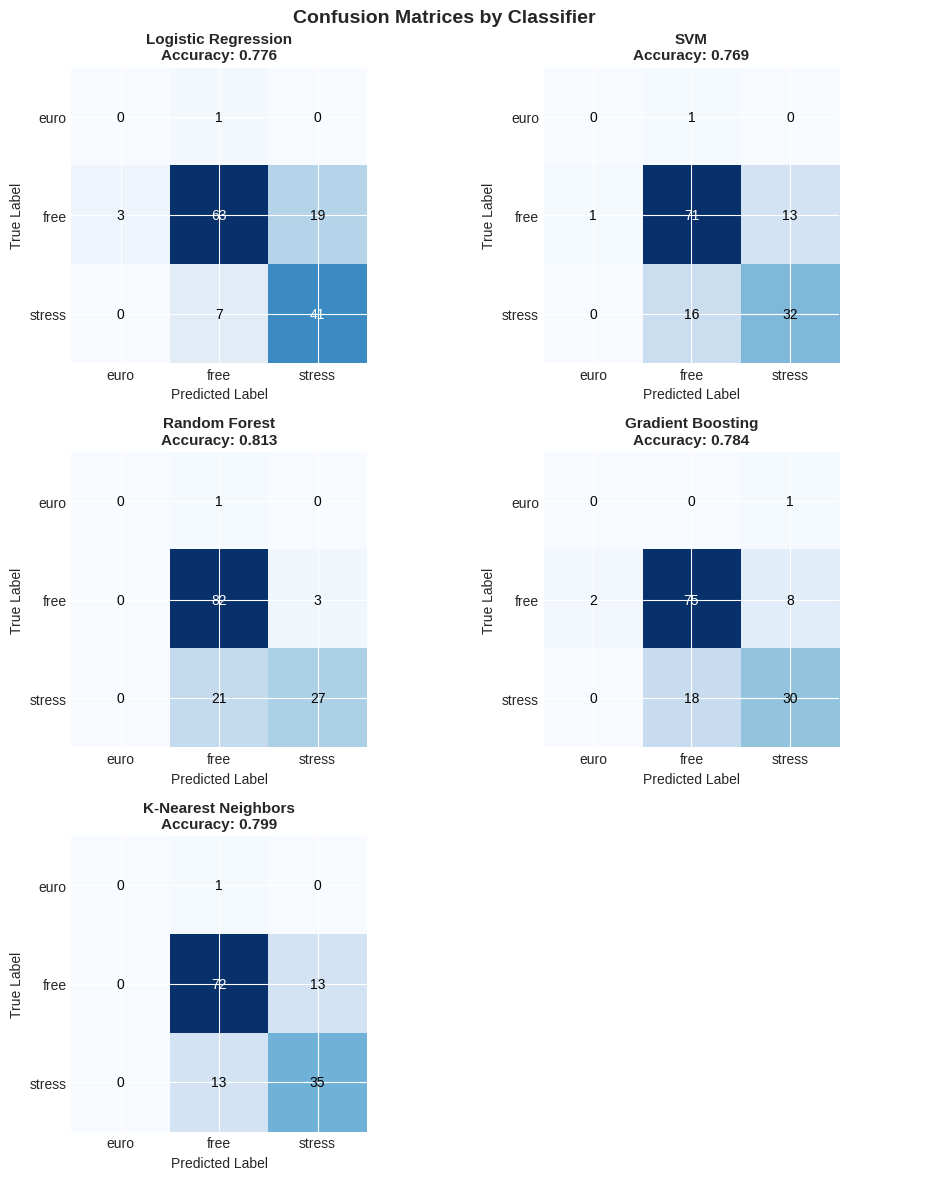


   Generating performance comparison...


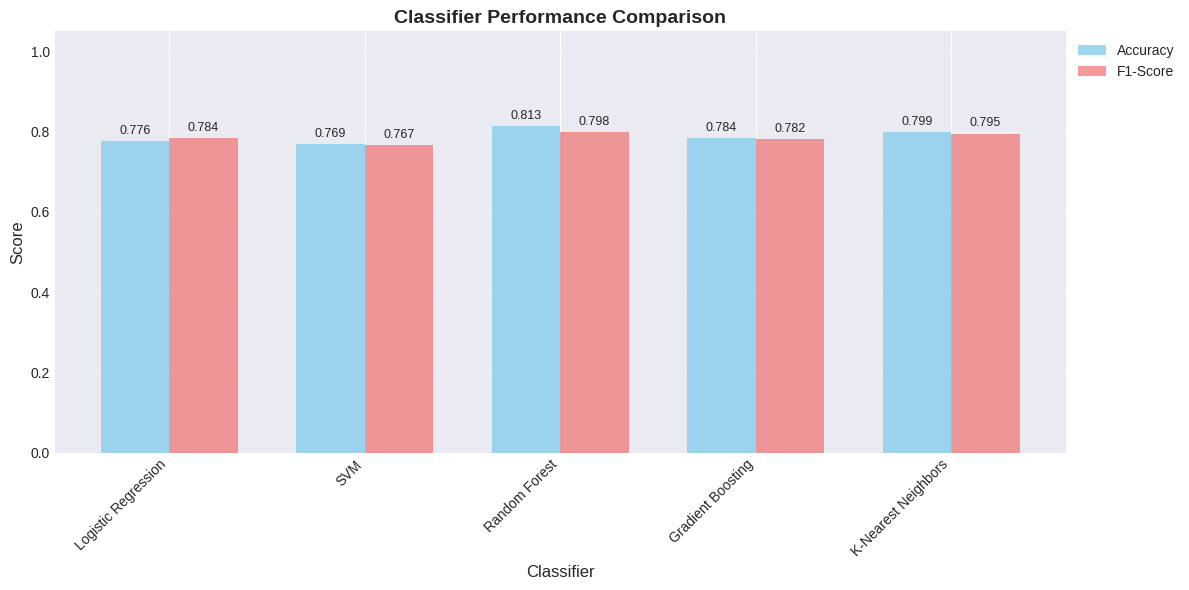


   Generating feature correlation heatmap...


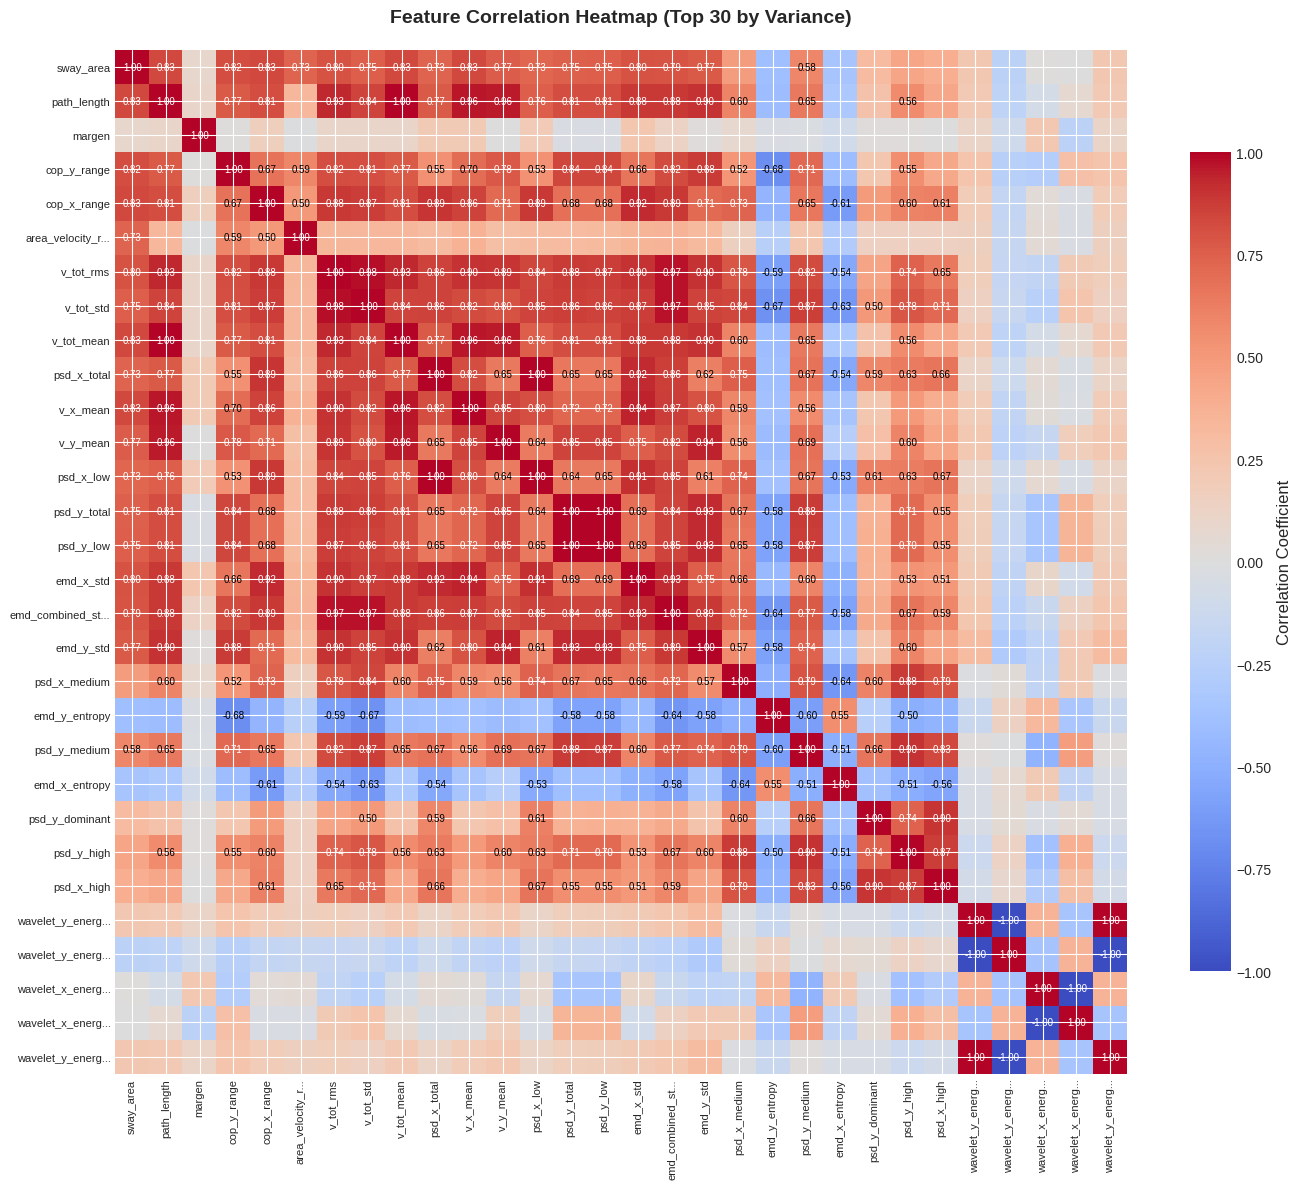


   Analyzing feature importance stability...


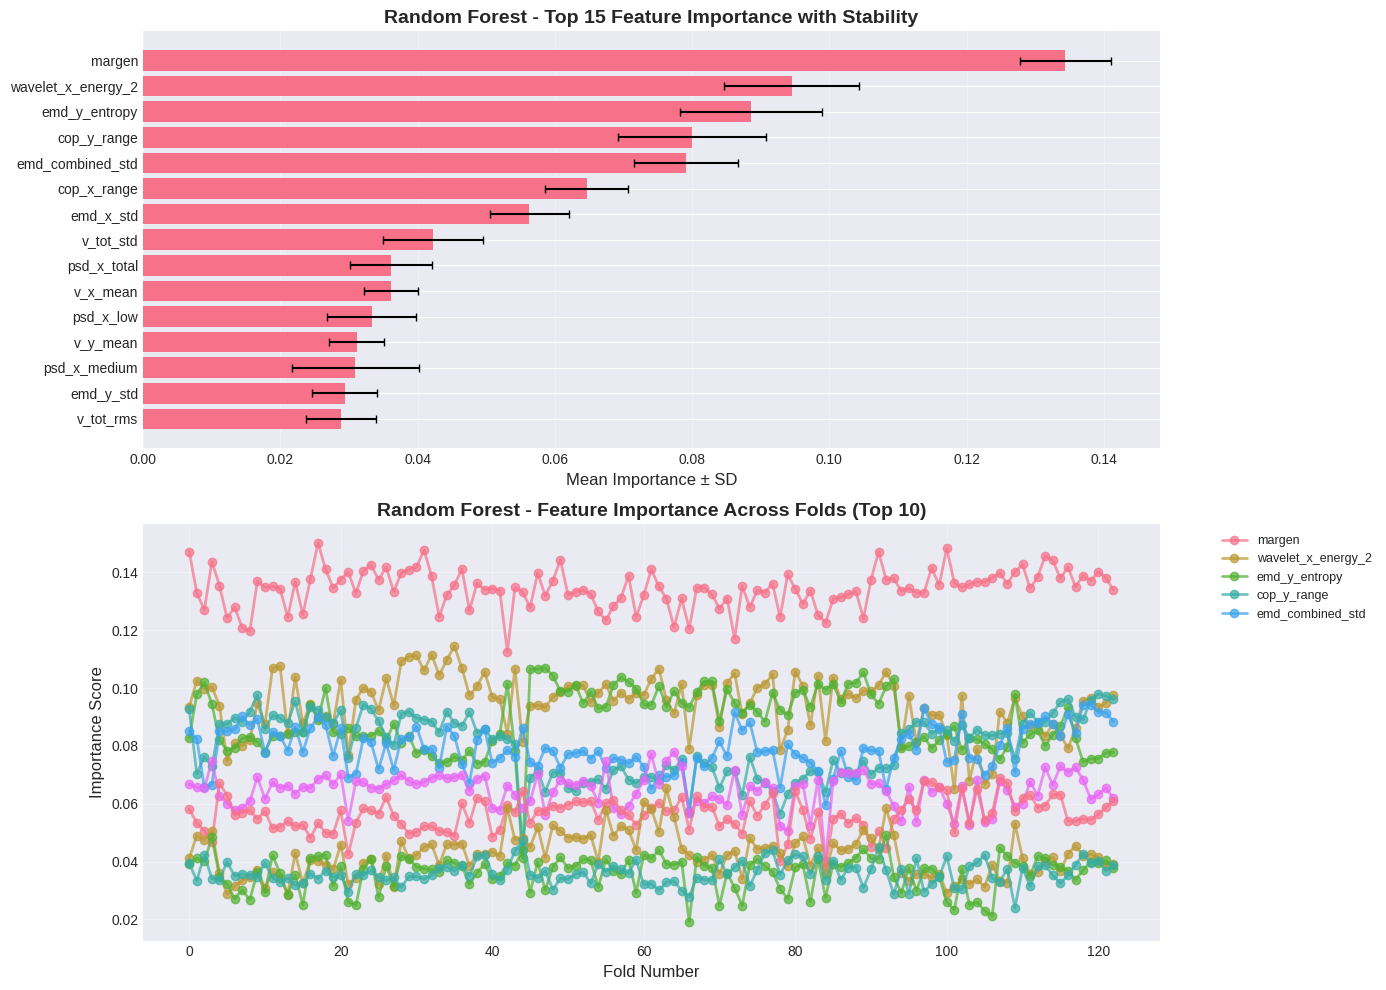

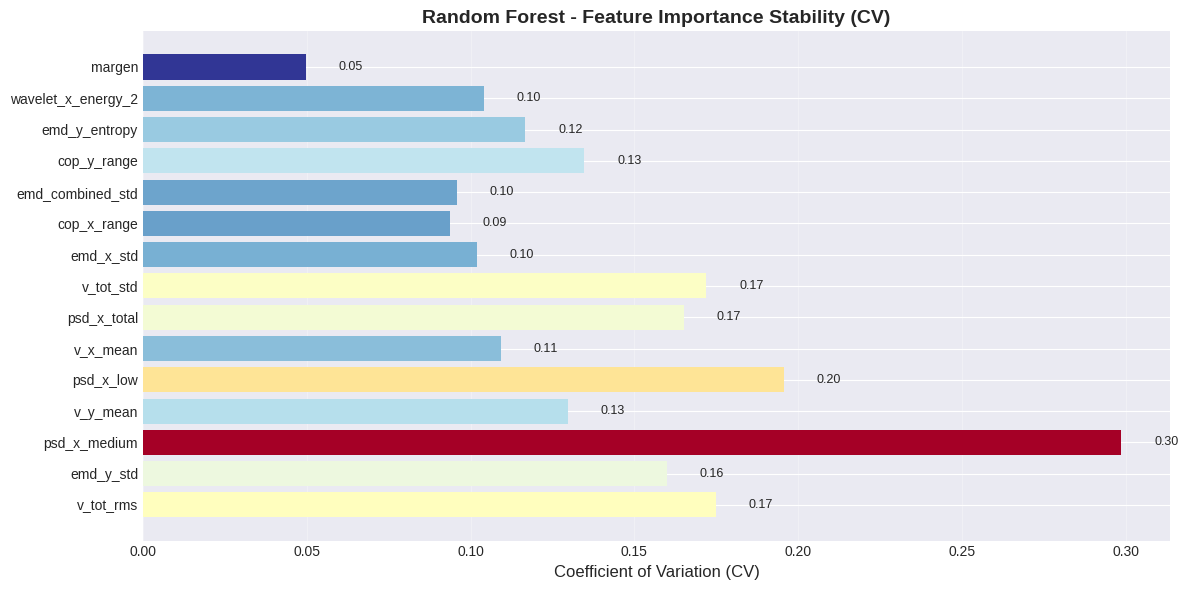

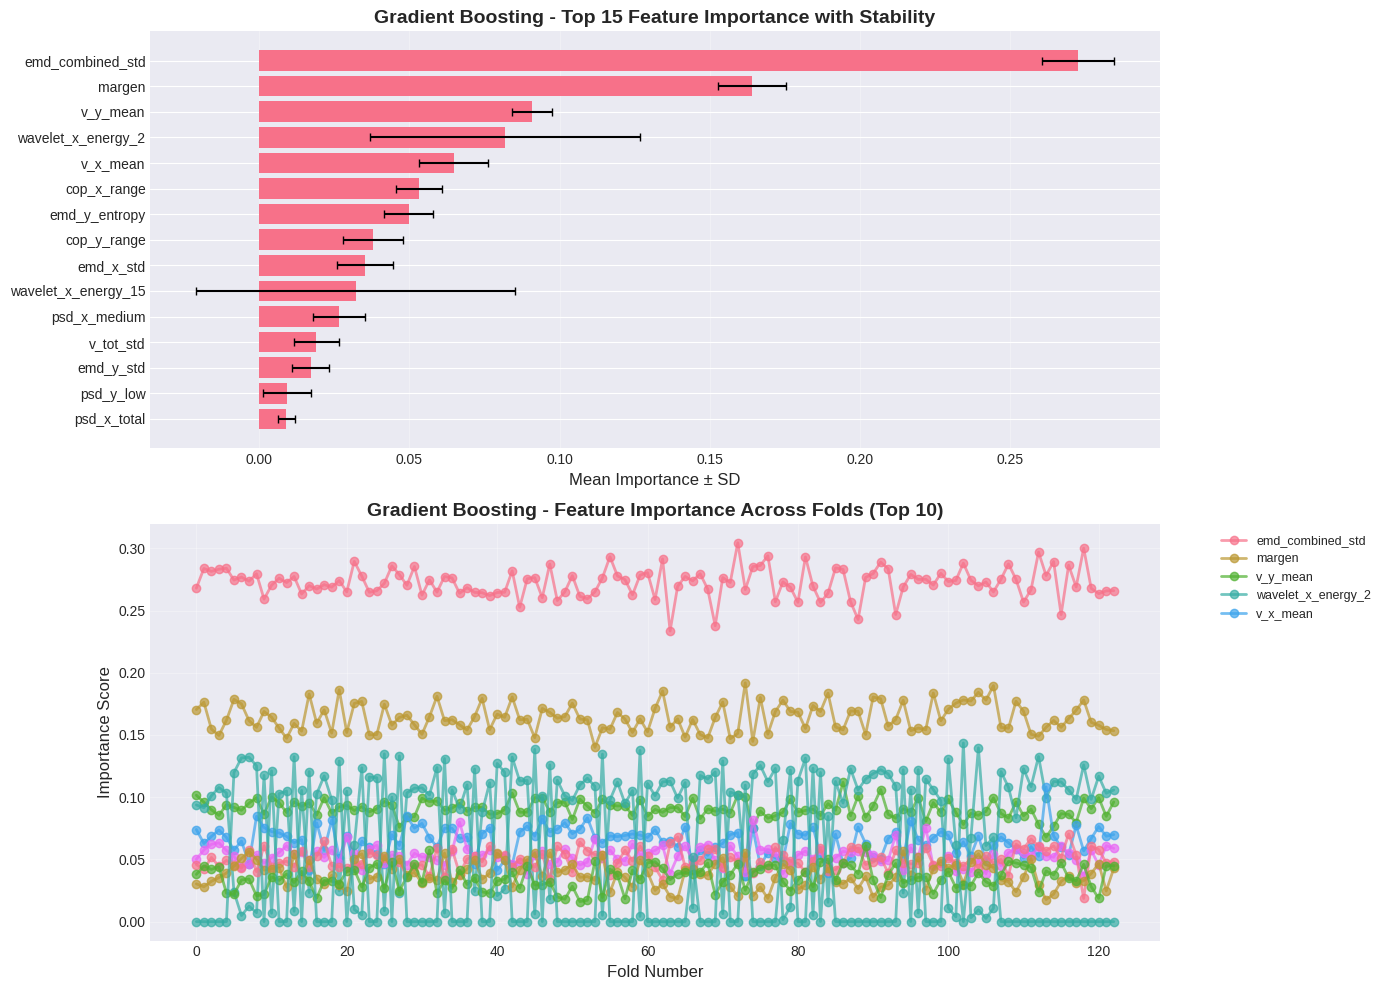

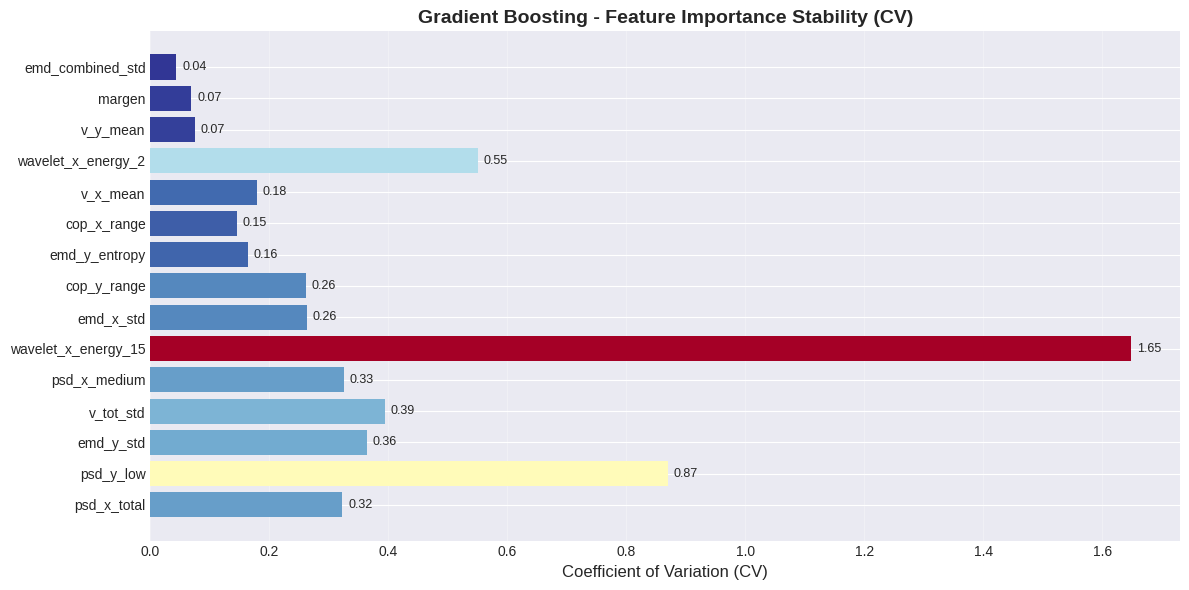


   Analyzing feature selection stability...


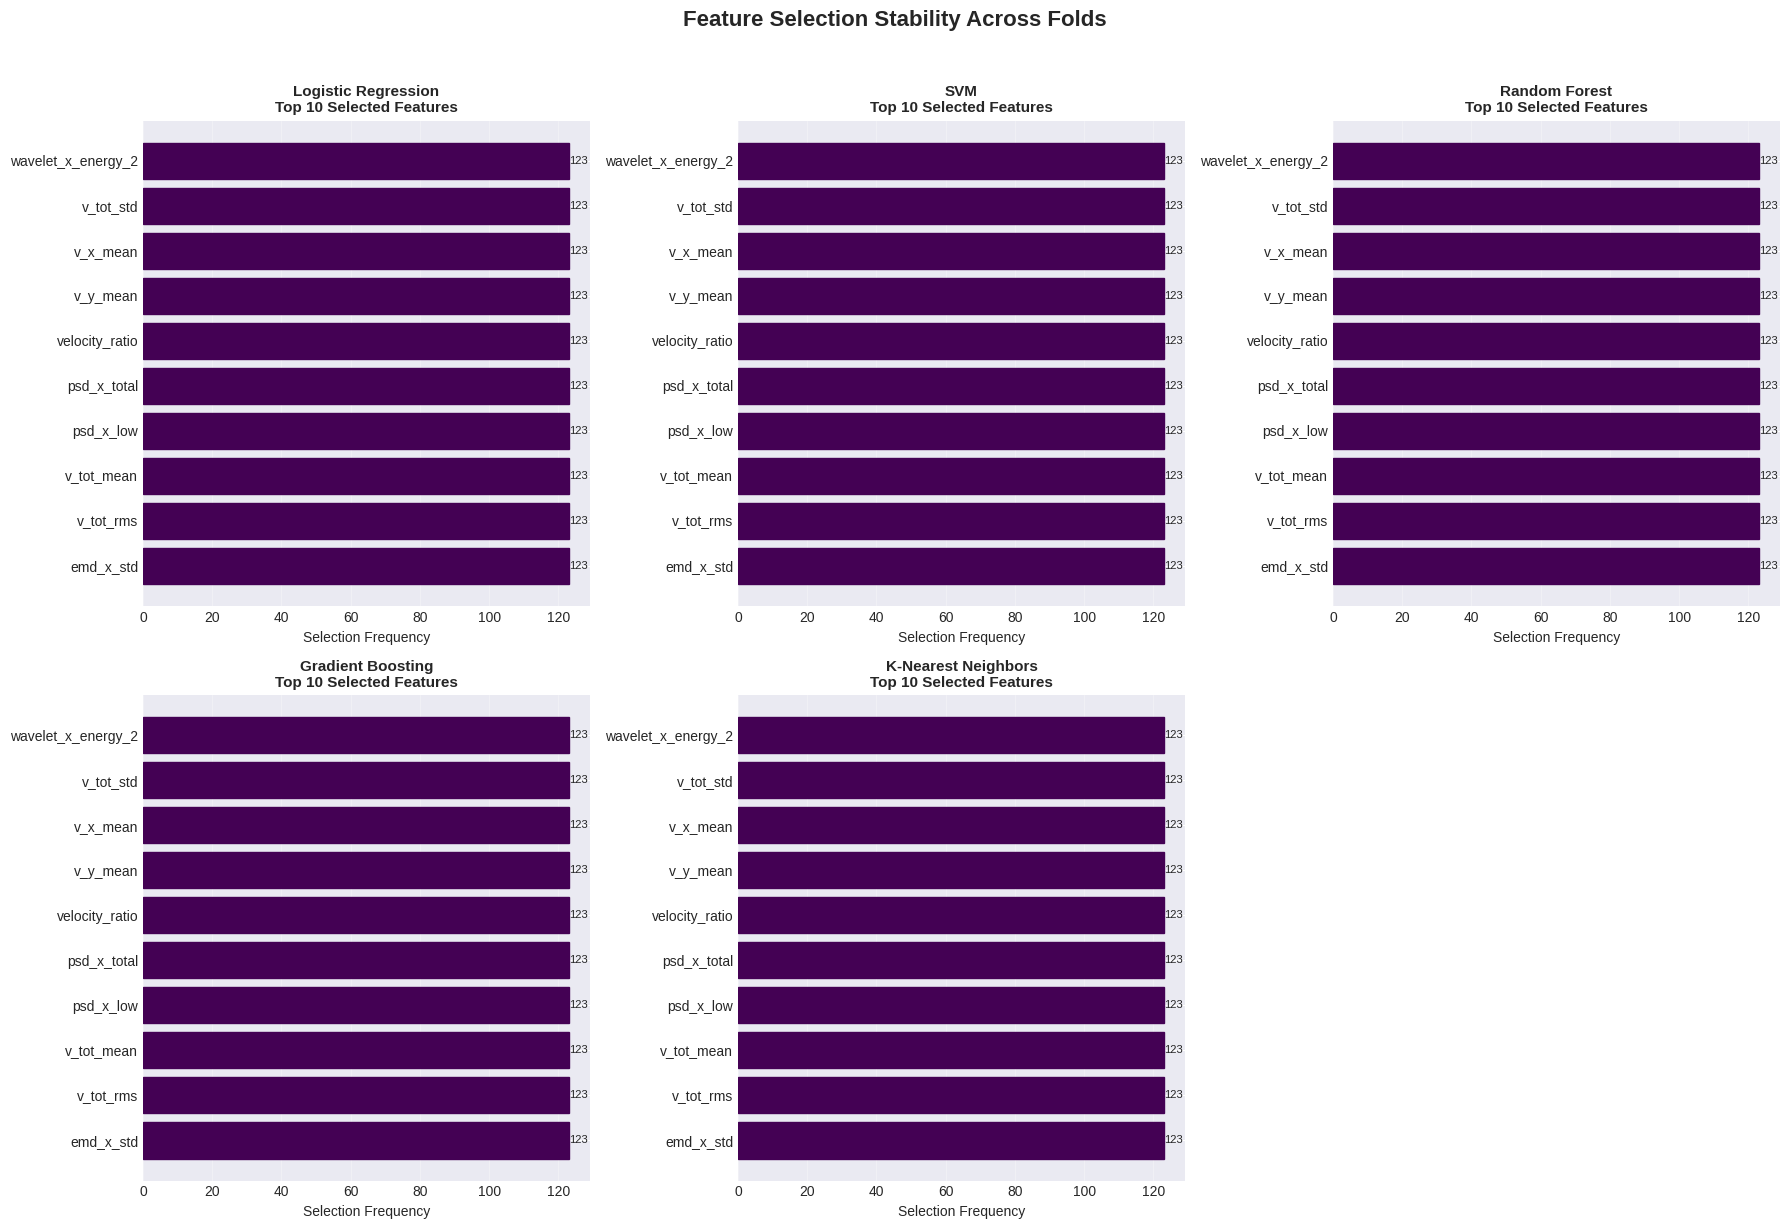


PERFORMANCE SUMMARY

Classifier                Accuracy   F1-Score  
---------------------------------------------
Random Forest             0.813      0.798     
K-Nearest Neighbors       0.799      0.795     
Gradient Boosting         0.784      0.782     
Logistic Regression       0.776      0.784     
SVM                       0.769      0.767     

Best Classifier: Random Forest
Accuracy: 0.813
F1-Score: 0.798

Per-class performance (best classifier):
  euro: Precision=0.000, Recall=0.000, F1=0.000
  free: Precision=0.788, Recall=0.965, F1=0.868
  stress: Precision=0.900, Recall=0.562, F1=0.692


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
import pywt
from PyEMD import EMD
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
emd_imfs = 5  # Number of IMFs to keep for detrending
FS = 250  # Sampling frequency (Hz)

def prepare_data(signal_df):
    """
    Prepare the data by filtering and selecting one trial per subject-condition pair
    """
    # Remove observations where sample no > 7500 and condition is stress
    mask = ~((signal_df['sample'] > 7500) & (signal_df['condition'] == 'stress'))
    df_filtered = signal_df[mask].copy()

    # Select one trial per (subject, condition) pair (first trial)
    selected_files = []
    for (subject, condition), group in df_filtered.groupby(['subject', 'condition']):
        trial_files = group['file'].unique()
        if len(trial_files) > 0:
            selected_files.append(trial_files[0])

    df_analysis = df_filtered[df_filtered['file'].isin(selected_files)].copy()

    # Ensure equal observation window for all conditions
    min_samples = df_analysis.groupby('file')['sample'].max().min()
    df_analysis = df_analysis[df_analysis['sample'] <= min_samples]

    return df_analysis

def filter_cop_data(cop_series, fs=FS, lowcut=0.5, highcut=20):
    """
    Apply bandpass filter to COP data
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')
    filtered = signal.filtfilt(b, a, cop_series)
    return filtered

# -------------------------
# TIME-DOMAIN FEATURES (BASELINE)
# -------------------------
def cop_time_features(cop_x, cop_y, fs=FS):
    """
    Extract time-domain COP features
    """
    dx = np.diff(cop_x)
    dy = np.diff(cop_y)
    velocity = np.sqrt(dx**2 + dy**2) * fs

    # Calculate mean velocity components
    vx = np.diff(cop_x) * fs
    vy = np.diff(cop_y) * fs

    # Sway area (95% confidence ellipse area)
    cov_matrix = np.cov(cop_x, cop_y)
    eigenvalues = np.linalg.eigvals(cov_matrix)
    if eigenvalues[0] > 0 and eigenvalues[1] > 0:
        sway_area = np.pi * 5.991 * np.sqrt(eigenvalues[0] * eigenvalues[1])  # 95% confidence ellipse
    else:
        sway_area = np.pi * np.std(cop_x) * np.std(cop_y) * 5.991

    return {
        "path_length": np.sum(np.sqrt(dx**2 + dy**2)),
        "v_tot_mean": np.mean(velocity),
        "v_tot_std": np.std(velocity),
        "v_tot_rms": np.sqrt(np.mean(velocity**2)),
        "v_x_mean": np.mean(np.abs(vx)),
        "v_y_mean": np.mean(np.abs(vy)),
        "sway_area": sway_area,
        "cop_x_range": np.max(cop_x) - np.min(cop_x),
        "cop_y_range": np.max(cop_y) - np.min(cop_y),
        "margen": np.mean(np.sqrt(cop_x**2 + cop_y**2))
    }

# -------------------------
# EMD DETREND
# -------------------------
def detrend_emd(signal_vals, n_imf=emd_imfs):
    """
    Detrend signal using Empirical Mode Decomposition
    """
    try:
        emd = EMD()
        imfs = emd(signal_vals)
        if len(imfs) < n_imf:
            return np.sum(imfs, axis=0), len(imfs)
        return np.sum(imfs[:n_imf], axis=0), n_imf
    except:
        # Fallback: remove linear trend
        t = np.arange(len(signal_vals))
        coeff = np.polyfit(t, signal_vals, 1)
        trend = np.polyval(coeff, t)
        return signal_vals - trend, 0

# -------------------------
# WAVELET PACKET (MEDIUM FREQUENCY – LAYER 4)
# -------------------------
def wavelet_layer4_energy(signal_vals, wavelet="sym4", level=4):
    """
    Extract wavelet packet energies from level 4
    """
    try:
        wp = pywt.WaveletPacket(
            data=signal_vals, wavelet=wavelet,
            mode="symmetric", maxlevel=level
        )
        nodes = wp.get_level(level, order="freq")
        energies = [np.sum(node.data**2) for node in nodes]

        # Normalize energies
        total_energy = np.sum(energies)
        if total_energy > 0:
            energies = [e/total_energy for e in energies]

        return energies
    except:
        # Return zeros if wavelet decomposition fails
        return [0.0] * (2**level)

def extract_emd_features(cop_x, cop_y):
    """
    Extract features from EMD-detrended signals
    """
    # Detrend signals
    cop_x_detrended, n_imf_x = detrend_emd(cop_x)
    cop_y_detrended, n_imf_y = detrend_emd(cop_y)

    # Extract features from detrended signals
    features = {}

    # Amplitude features
    features['emd_x_std'] = np.std(cop_x_detrended)
    features['emd_y_std'] = np.std(cop_y_detrended)
    features['emd_combined_std'] = np.std(np.sqrt(cop_x_detrended**2 + cop_y_detrended**2))

    # Complexity features
    features['emd_x_entropy'] = stats.entropy(np.histogram(cop_x_detrended, bins=20, density=True)[0])
    features['emd_y_entropy'] = stats.entropy(np.histogram(cop_y_detrended, bins=20, density=True)[0])

    # IMF count
    features['n_imf_x'] = n_imf_x
    features['n_imf_y'] = n_imf_y

    return features

def extract_frequency_features(cop_x, cop_y, fs=FS):
    """
    Extract frequency-domain features
    """
    features = {}

    # Power spectral density features
    for direction, signal_vals in [('x', cop_x), ('y', cop_y)]:
        f, Pxx = signal.welch(signal_vals, fs=fs, nperseg=min(256, len(signal_vals)))

        if len(Pxx) > 0:
            # Frequency band features
            idx_low = (f >= 0.5) & (f < 2)
            idx_medium = (f >= 2) & (f < 6)
            idx_high = (f >= 6) & (f <= 20)

            features[f'psd_{direction}_low'] = np.sum(Pxx[idx_low]) if np.any(idx_low) else 0
            features[f'psd_{direction}_medium'] = np.sum(Pxx[idx_medium]) if np.any(idx_medium) else 0
            features[f'psd_{direction}_high'] = np.sum(Pxx[idx_high]) if np.any(idx_high) else 0
            features[f'psd_{direction}_total'] = np.sum(Pxx)

            # Dominant frequency
            if np.max(Pxx) > 0:
                dominant_freq = f[np.argmax(Pxx)]
                features[f'psd_{direction}_dominant'] = dominant_freq

    return features

def extract_all_features(cop_x, cop_y, fs=FS):
    """
    Extract all features from COP signals using the specified methods
    """
    features = {}

    # 1. Time-domain features (baseline)
    time_features = cop_time_features(cop_x, cop_y, fs)
    features.update(time_features)

    # 2. Filter signals
    cop_x_filtered = filter_cop_data(cop_x, fs)
    cop_y_filtered = filter_cop_data(cop_y, fs)

    # 3. EMD features
    emd_features = extract_emd_features(cop_x_filtered, cop_y_filtered)
    features.update(emd_features)

    # 4. Wavelet packet features (medium frequency - layer 4)
    wavelet_x_energies = wavelet_layer4_energy(cop_x_filtered)
    wavelet_y_energies = wavelet_layer4_energy(cop_y_filtered)

    # Add wavelet energy features
    for i, energy in enumerate(wavelet_x_energies):
        features[f'wavelet_x_energy_{i}'] = energy

    for i, energy in enumerate(wavelet_y_energies):
        features[f'wavelet_y_energy_{i}'] = energy

    # Wavelet statistical features
    features['wavelet_x_energy_mean'] = np.mean(wavelet_x_energies)
    features['wavelet_x_energy_std'] = np.std(wavelet_x_energies)
    features['wavelet_y_energy_mean'] = np.mean(wavelet_y_energies)
    features['wavelet_y_energy_std'] = np.std(wavelet_y_energies)

    # 5. Frequency domain features
    freq_features = extract_frequency_features(cop_x_filtered, cop_y_filtered, fs)
    features.update(freq_features)

    # 6. Additional composite features
    features['velocity_ratio'] = features['v_tot_mean'] / (features['path_length'] + 1e-10)
    features['area_velocity_ratio'] = features['sway_area'] / (features['v_tot_mean'] + 1e-10)

    return features

class CrossIndividualPipeline:
    def __init__(self, classifiers=None):
        if classifiers is None:
            self.classifiers = {
                'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
                'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
                'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
            }
        else:
            self.classifiers = classifiers

        # Store feature names and importance across folds
        self.feature_names = None
        self.feature_importance_history = {name: [] for name in self.classifiers.keys()}
        self.selected_features_history = {name: [] for name in self.classifiers.keys()}

    def extract_features_per_trial(self, df):
        """
        Extract features for each trial
        """
        features_list = []
        labels = []
        subjects = []
        all_feature_names = None

        for file_name, trial_data in df.groupby('file'):
            subject = trial_data['subject'].iloc[0]
            condition = trial_data['condition'].iloc[0]

            # Get COP data
            cop_x = trial_data['cop_x'].values
            cop_y = trial_data['cop_y'].values

            # Extract all features
            trial_features = extract_all_features(cop_x, cop_y)

            # Store feature names from first trial
            if all_feature_names is None:
                all_feature_names = list(trial_features.keys())

            # Convert to array
            feature_array = np.array([trial_features[name] for name in all_feature_names])

            features_list.append(feature_array)
            labels.append(condition)
            subjects.append(subject)

        self.feature_names = np.array(all_feature_names)
        return np.array(features_list), np.array(labels), np.array(subjects)

    def plot_confusion_matrices(self, results, label_encoder=None):
        """
        Plot confusion matrices for all classifiers
        """
        n_classifiers = len(self.classifiers)
        n_rows = int(np.ceil(n_classifiers / 2))
        n_cols = 2

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        axes = axes.flatten()

        for idx, (name, result) in enumerate(results.items()):
            y_true = result['true']
            y_pred = result['pred']

            # Get unique classes
            classes = sorted(list(set(y_true) | set(y_pred)))

            # Create confusion matrix
            cm = confusion_matrix(y_true, y_pred, labels=classes)

            # Plot
            ax = axes[idx]
            im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
            ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_true, y_pred):.3f}',
                        fontsize=11, fontweight='bold')

            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    ax.text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center",
                           color="white" if cm[i, j] > thresh else "black",
                           fontsize=10)

            # Set labels
            ax.set_xlabel('Predicted Label', fontsize=10)
            ax.set_ylabel('True Label', fontsize=10)
            ax.set_xticks(range(len(classes)))
            ax.set_yticks(range(len(classes)))
            ax.set_xticklabels(classes)
            ax.set_yticklabels(classes)

        # Hide empty subplots
        for idx in range(len(results), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Confusion Matrices by Classifier', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_feature_importance_stability(self, top_n=15):
        """
        Plot feature importance stability across folds for tree-based models
        """
        tree_models = ['Random Forest', 'Gradient Boosting']

        for model_name in tree_models:
            if model_name in self.feature_importance_history and len(self.feature_importance_history[model_name]) > 0:
                importances = np.array(self.feature_importance_history[model_name])

                # Calculate mean and std importance
                mean_importance = np.mean(importances, axis=0)
                std_importance = np.std(importances, axis=0)

                # Get top N features
                top_indices = np.argsort(mean_importance)[-top_n:][::-1]
                top_features = self.feature_names[top_indices]
                top_mean = mean_importance[top_indices]
                top_std = std_importance[top_indices]

                # Create figure
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

                # Plot 1: Mean feature importance with error bars
                y_pos = np.arange(len(top_features))
                ax1.barh(y_pos, top_mean, xerr=top_std, capsize=3)
                ax1.set_yticks(y_pos)
                ax1.set_yticklabels(top_features)
                ax1.invert_yaxis()
                ax1.set_xlabel('Mean Importance ± SD', fontsize=12)
                ax1.set_title(f'{model_name} - Top {top_n} Feature Importance with Stability',
                            fontsize=14, fontweight='bold')
                ax1.grid(True, alpha=0.3, axis='x')

                # Plot 2: Feature importance across folds (line plot)
                for i, idx in enumerate(top_indices[:10]):  # Top 10 features
                    ax2.plot(range(len(importances)), importances[:, idx],
                            marker='o', linewidth=2, alpha=0.7,
                            label=top_features[i] if i < 5 else None)  # Label only first 5

                ax2.set_xlabel('Fold Number', fontsize=12)
                ax2.set_ylabel('Importance Score', fontsize=12)
                ax2.set_title(f'{model_name} - Feature Importance Across Folds (Top 10)',
                            fontsize=14, fontweight='bold')
                ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
                ax2.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()

                # Plot 3: Coefficient of variation (stability metric)
                fig3, ax3 = plt.subplots(figsize=(12, 6))
                cv = std_importance[top_indices] / (mean_importance[top_indices] + 1e-10)

                colors = plt.cm.RdYlBu_r((cv - cv.min()) / (cv.max() - cv.min()))
                bars = ax3.barh(y_pos, cv, color=colors)

                ax3.set_yticks(y_pos)
                ax3.set_yticklabels(top_features)
                ax3.invert_yaxis()
                ax3.set_xlabel('Coefficient of Variation (CV)', fontsize=12)
                ax3.set_title(f'{model_name} - Feature Importance Stability (CV)',
                            fontsize=14, fontweight='bold')
                ax3.grid(True, alpha=0.3, axis='x')

                # Add CV values
                for i, v in enumerate(cv):
                    ax3.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=9)

                plt.tight_layout()
                plt.show()

    def plot_feature_selection_stability(self):
        """
        Plot feature selection stability across folds
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.flat

        for idx, (name, selected_lists) in enumerate(self.selected_features_history.items()):
            if idx >= len(axes):
                break

            if len(selected_lists) == 0:
                axes[idx].text(0.5, 0.5, f'No feature selection\nfor {name}',
                             ha='center', va='center', fontsize=12)
                axes[idx].axis('off')
                continue

            ax = axes[idx]

            # Count selection frequency
            all_selected = []
            for fold_selected in selected_lists:
                all_selected.extend(fold_selected)

            if len(all_selected) == 0:
                ax.text(0.5, 0.5, 'No features selected',
                       ha='center', va='center', fontsize=12)
                ax.axis('off')
                continue

            unique_features, counts = np.unique(all_selected, return_counts=True)

            # Get top 10 most frequently selected
            top_n = min(10, len(unique_features))
            if top_n > 0:
                top_indices = np.argsort(counts)[-top_n:][::-1]
                top_features = unique_features[top_indices]
                top_counts = counts[top_indices]

                # Plot
                y_pos = np.arange(top_n)
                bars = ax.barh(y_pos, top_counts)

                # Color by count
                norm = plt.Normalize(top_counts.min(), top_counts.max())
                cmap = plt.cm.viridis
                for bar, count in zip(bars, top_counts):
                    bar.set_color(cmap(norm(count)))

                ax.set_yticks(y_pos)
                # Truncate long feature names
                feature_labels = []
                for f in top_features:
                    if len(f) > 25:
                        feature_labels.append(f[:22] + '...')
                    else:
                        feature_labels.append(f)
                ax.set_yticklabels(feature_labels)
                ax.invert_yaxis()
                ax.set_xlabel('Selection Frequency', fontsize=10)
                ax.set_title(f'{name}\nTop {top_n} Selected Features',
                           fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3, axis='x')

                # Add count values
                for i, v in enumerate(top_counts):
                    ax.text(v + 0.1, i, str(v), va='center', fontsize=8)

        # Hide empty subplots
        for idx in range(len(self.selected_features_history), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Feature Selection Stability Across Folds',
                    fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    def cross_individual_validation(self, X, y, subjects, k_features=20):
        """
        Perform cross-individual validation with feature importance tracking
        """
        unique_subjects = np.unique(subjects)
        results = {name: {'true': [], 'pred': [], 'proba': []} for name in self.classifiers.keys()}

        # Reset history
        self.feature_importance_history = {name: [] for name in self.classifiers.keys()}
        self.selected_features_history = {name: [] for name in self.classifiers.keys()}

        print(f"  Performing {len(unique_subjects)}-fold cross-individual validation...")

        fold_num = 0
        for test_subject in unique_subjects:
            fold_num += 1

            # Split data
            train_mask = subjects != test_subject
            test_mask = subjects == test_subject

            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]

            # Handle class imbalance
            from sklearn.utils.class_weight import compute_class_weight
            class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
            class_weight_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

            # Scale features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # Feature selection using ANOVA
            k = min(k_features, X_train.shape[1])
            selector = SelectKBest(f_classif, k=k)
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            # Get selected feature indices and names
            selected_indices = selector.get_support(indices=True)
            selected_names = self.feature_names[selected_indices]

            # Train and evaluate each classifier
            for name, clf in self.classifiers.items():
                # Update class weights for classifiers that support it
                if hasattr(clf, 'class_weight'):
                    clf.set_params(class_weight=class_weight_dict)

                # Train
                clf.fit(X_train_selected, y_train)

                # Store selected features
                self.selected_features_history[name].append(selected_names)

                # Get feature importance
                importance = np.zeros(len(self.feature_names))

                if hasattr(clf, 'feature_importances_'):
                    # Tree-based models
                    importance[selected_indices] = clf.feature_importances_
                elif hasattr(clf, 'coef_'):
                    # Linear models
                    if len(clf.coef_.shape) == 1:
                        importance[selected_indices] = np.abs(clf.coef_)
                    else:
                        importance[selected_indices] = np.mean(np.abs(clf.coef_), axis=0)
                else:
                    # For models without feature importance, use ANOVA F-scores
                    f_scores = selector.scores_[selected_indices]
                    importance[selected_indices] = f_scores / np.sum(f_scores) if np.sum(f_scores) > 0 else 0

                self.feature_importance_history[name].append(importance)

                # Predict
                y_pred = clf.predict(X_test_selected)
                if hasattr(clf, 'predict_proba'):
                    y_proba = clf.predict_proba(X_test_selected)
                else:
                    y_proba = None

                # Store results
                results[name]['true'].extend(y_test)
                results[name]['pred'].extend(y_pred)
                if y_proba is not None:
                    results[name]['proba'].extend(y_proba)

        return results

    def evaluate_results(self, results):
        """
        Evaluate and compare classifier performance
        """
        performance = {}

        for name, result in results.items():
            y_true = result['true']
            y_pred = result['pred']

            # Calculate metrics
            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')

            # Get classification report
            report = classification_report(y_true, y_pred, output_dict=True)

            performance[name] = {
                'accuracy': acc,
                'f1_score': f1,
                'classification_report': report
            }

        return performance

def plot_performance_comparison(performance):
    """
    Plot performance comparison across classifiers
    """
    classifiers = list(performance.keys())
    accuracies = [performance[clf]['accuracy'] for clf in classifiers]
    f1_scores = [performance[clf]['f1_score'] for clf in classifiers]

    x = np.arange(len(classifiers))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', color='lightcoral', alpha=0.8)

    ax.set_xlabel('Classifier', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Classifier Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classifiers, rotation=45, ha='right')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])

    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_feature_correlation_heatmap(feature_matrix, feature_names, top_n=30):
    """
    Plot correlation heatmap of top features
    """
    # Calculate correlations
    corr_matrix = np.corrcoef(feature_matrix.T)

    # Get features with highest variance
    variances = np.var(feature_matrix, axis=0)
    top_indices = np.argsort(variances)[-top_n:][::-1]
    top_features = feature_names[top_indices]

    # Get sub-correlation matrix
    sub_corr = corr_matrix[top_indices][:, top_indices]

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(14, 12))
    im = ax.imshow(sub_corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

    # Set labels
    ax.set_xticks(range(len(top_features)))
    ax.set_yticks(range(len(top_features)))
    ax.set_xticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features],
                       rotation=90, fontsize=8)
    ax.set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in top_features],
                       fontsize=8)

    ax.set_title('Feature Correlation Heatmap (Top 30 by Variance)',
                fontsize=14, fontweight='bold', pad=20)

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation Coefficient', fontsize=12)

    # Add correlation values
    threshold = 0.5
    for i in range(len(top_features)):
        for j in range(len(top_features)):
            if abs(sub_corr[i, j]) > threshold:
                color = 'white' if abs(sub_corr[i, j]) > 0.7 else 'black'
                ax.text(j, i, f'{sub_corr[i, j]:.2f}',
                       ha='center', va='center', color=color, fontsize=7)

    plt.tight_layout()
    plt.show()

def main_pipeline(signal_df):
    """
    Main pipeline execution with visualization
    """
    print("="*70)
    print("CROSS-INDIVIDUAL COP CLASSIFICATION PIPELINE")
    print("="*70)
    print(f"Using features: Time-domain, EMD detrending, Wavelet Packet (layer 4)")
    print(f"EMD IMFs: {emd_imfs}, Sampling Frequency: {FS} Hz")
    print("="*70)

    print("\nStep 1: Preparing data...")
    df_prepared = prepare_data(signal_df)

    print(f"   Number of trials: {df_prepared['file'].nunique()}")
    print(f"   Subjects: {df_prepared['subject'].nunique()}")
    print(f"   Conditions: {df_prepared['condition'].unique().tolist()}")
    print(f"   Samples per trial: {df_prepared.groupby('file')['sample'].count().mean():.0f}")

    print("\nStep 2: Extracting features...")
    pipeline = CrossIndividualPipeline()
    X, y, subjects = pipeline.extract_features_per_trial(df_prepared)

    print(f"   Feature matrix shape: {X.shape}")
    print(f"   Number of features: {X.shape[1]}")
    print(f"   Feature names (first 10): {pipeline.feature_names[:10]}")

    print("\nStep 3: Cross-individual validation...")
    results = pipeline.cross_individual_validation(X, y, subjects, k_features=20)

    print("\nStep 4: Evaluating classifiers...")
    performance = pipeline.evaluate_results(results)

    print("\nStep 5: Visualizing results...")

    # 1. Plot confusion matrices
    print("\n   Generating confusion matrices...")
    pipeline.plot_confusion_matrices(results)

    # 2. Plot performance comparison
    print("\n   Generating performance comparison...")
    plot_performance_comparison(performance)

    # 3. Plot feature correlation heatmap
    print("\n   Generating feature correlation heatmap...")
    plot_feature_correlation_heatmap(X, pipeline.feature_names, top_n=30)

    # 4. Plot feature importance stability
    print("\n   Analyzing feature importance stability...")
    pipeline.plot_feature_importance_stability(top_n=15)

    # 5. Plot feature selection stability
    print("\n   Analyzing feature selection stability...")
    pipeline.plot_feature_selection_stability()

    # Print summary
    print("\n" + "="*70)
    print("PERFORMANCE SUMMARY")
    print("="*70)

    print(f"\n{'Classifier':<25} {'Accuracy':<10} {'F1-Score':<10}")
    print("-"*45)

    sorted_perf = sorted(performance.items(), key=lambda x: x[1]['accuracy'], reverse=True)
    for name, metrics in sorted_perf:
        print(f"{name:<25} {metrics['accuracy']:<10.3f} {metrics['f1_score']:<10.3f}")

    # Best classifier details
    best_name, best_metrics = sorted_perf[0]
    print(f"\nBest Classifier: {best_name}")
    print(f"Accuracy: {best_metrics['accuracy']:.3f}")
    print(f"F1-Score: {best_metrics['f1_score']:.3f}")

    # Per-class metrics
    print("\nPer-class performance (best classifier):")
    report = best_metrics['classification_report']
    for class_name in report:
        if class_name not in ['accuracy', 'macro avg', 'weighted avg'] and 'support' not in class_name:
            metrics = report[class_name]
            print(f"  {class_name}: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}")

    return {
        'prepared_data': df_prepared,
        'feature_matrix': X,
        'labels': y,
        'subjects': subjects,
        'feature_names': pipeline.feature_names,
        'results': results,
        'performance': performance,
        'pipeline': pipeline
    }

# Example usage with synthetic data
if __name__ == "__main__":


    # Run pipeline
    results = main_pipeline(signal_df)

In [35]:
agg_df

subject condition    path_length    v_tot_rms     sway_area  \
0          2      free     302.469244    12.315718  2.371585e+02   
1          7      free     249.676458    10.081404  1.233501e+02   
2          8      free     245.760214     9.818617  2.071106e+02   
3          9      free     209.705313     8.242220  7.964721e+01   
4         10      free     260.478255    10.578842  2.917658e+02   
..       ...       ...            ...          ...           ...   
129      125    stress  213057.130555  4735.453501  6.666944e+08   
130      126      free     311.444183    12.786538  2.168562e+02   
131      127      free     321.380365    13.204781  2.829200e+02   
132      128      free     308.380138    11.938444  1.837528e+02   
133      129      free     528.147487    20.720320  6.683831e+02   

     L4_emd_energy_0  L4_emd_energy_1  L4_emd_energy_2  L4_emd_energy_3  \
0       6.391093e+05         2.444312         0.106576         0.077437   
1       2.545911e+05         0.636141         0.027592         0.033804   
2       1.000002e+06         1.413236         0.071818         0.042647   
3       6.071403e+04         0.797778         0.016727         0.022366   
4       8.680157e+05         1.934102         0.036419         0.038540   
..               ...              ...              ...              ...   
129     1.446508e+12     57949.959170     12745.701066      2313.039399   
130     7.963912e+05         2.636462         0.061739         0.046571   
131     1.176977e+06         3.699417         0.162715         0.127406   
132     4.372687e+05         2.855064         0.028178         0.057021   
133     7.490733e+05         9.316727         0.163484         0.137531   

     L4_emd_energy_4  ...  L4_emd_energy_6  L4_emd_energy_7  L4_emd_energy_8  \
0           0.062239  ...         0.010583         0.004335         0.001724   
1           0.015626  ...         0.003023         0.001110         0.000418   
2           0.044291  ...         0.006206         0.002650         0.001142   
3           0.006488  ...         0.000713         0.000352         0.000150   
4           0.019700  ...         0.003345         0.001375         0.000531   
..               ...  ...              ...              ...              ...   
129      7873.805974  ...      1214.830212       521.336157       233.657093   
130         0.034307  ...         0.005510         0.002397         0.000945   
131         0.095786  ...         0.012997         0.005714         0.002765   
132         0.014933  ...         0.002746         0.001136         0.000339   
133         0.089843  ...         0.012938         0.005782         0.002280   

     L4_emd_energy_9  L4_emd_energy_10  L4_emd_energy_11  L4_emd_energy_12  \
0           0.002554          0.000494          0.002316          0.000102   
1           0.000638          0.000125          0.000604          0.000058   
2           0.001730          0.000349          0.001567          0.000110   
3           0.000303          0.000080          0.000233          0.000065   
4           0.000799          0.000159          0.000725          0.000042   
..               ...               ...               ...               ...   
129       329.512129         59.538218        300.821706          2.243493   
130         0.001369          0.000260          0.001249          0.000039   
131         0.003724          0.000893          0.003271          0.000338   
132         0.000620          0.000152          0.000512          0.000091   
133         0.003360          0.000696          0.002925          0.000136   

     L4_emd_energy_13  L4_emd_energy_14  L4_emd_energy_15  
0            0.000157          0.000166          0.000181  
1            0.000043          0.000041          0.000043  
2            0.000104          0.000107          0.000120  
3            0.000034          0.000011          0.000013  
4            0.000051          0.000051          0.000056  
..                ...        

#Task 2 : Trial number prediction


Sample data created: 8276763 rows
Subjects: 12, Trials per subject: 20
TRIAL BIN CLASSIFICATION PIPELINE
Bins: Early (trials 1-3), Mid (4-7), Last (8-10)
Preparing binned trial classification data...
Downsampling to 1500 samples per trial...

Trial bin distribution:
trial_bin
Early    347
Mid      340
Last     310
Name: count, dtype: int64
Extracting features for each trial...
  Processed 0/997 trials
  Processed 50/997 trials
  Processed 100/997 trials
  Processed 150/997 trials
  Processed 200/997 trials
  Processed 250/997 trials
  Processed 300/997 trials
  Processed 350/997 trials
  Processed 400/997 trials
  Processed 450/997 trials
  Processed 500/997 trials
  Processed 550/997 trials
  Processed 600/997 trials
  Processed 650/997 trials
  Processed 700/997 trials
  Processed 750/997 trials
  Processed 800/997 trials
  Processed 850/997 trials
  Processed 900/997 trials
  Processed 950/997 trials

Extracted 997 trials with 23 features
Class distribution: {'Last': 347, 'Mid': 34

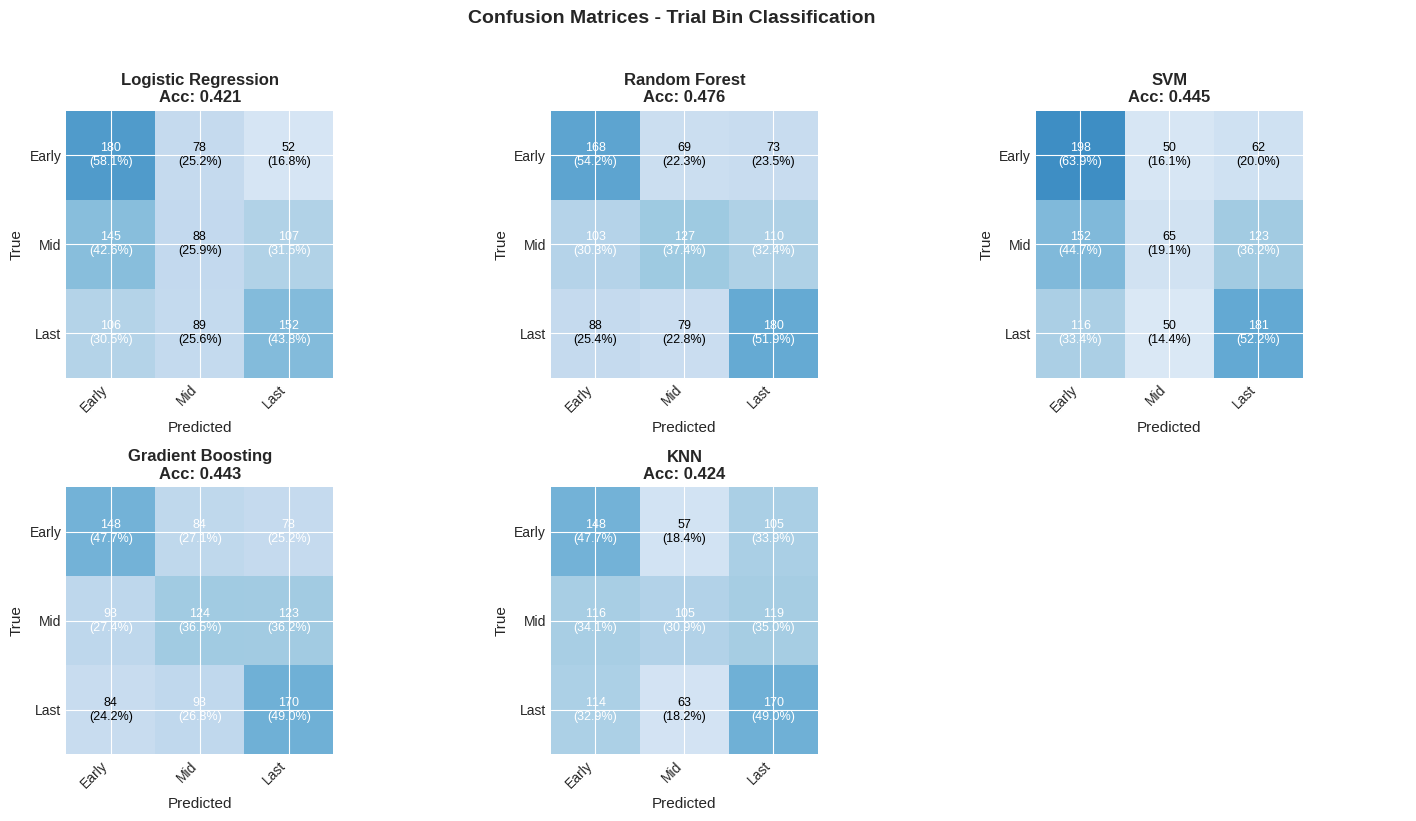

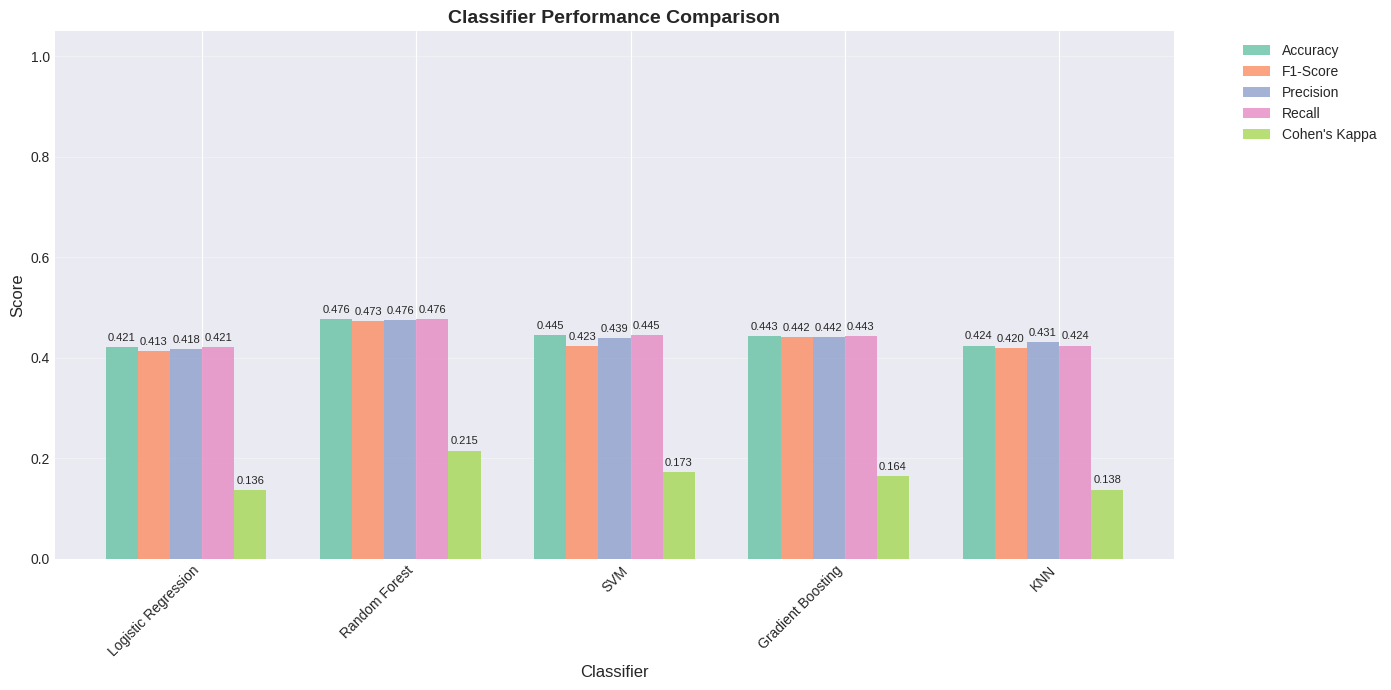

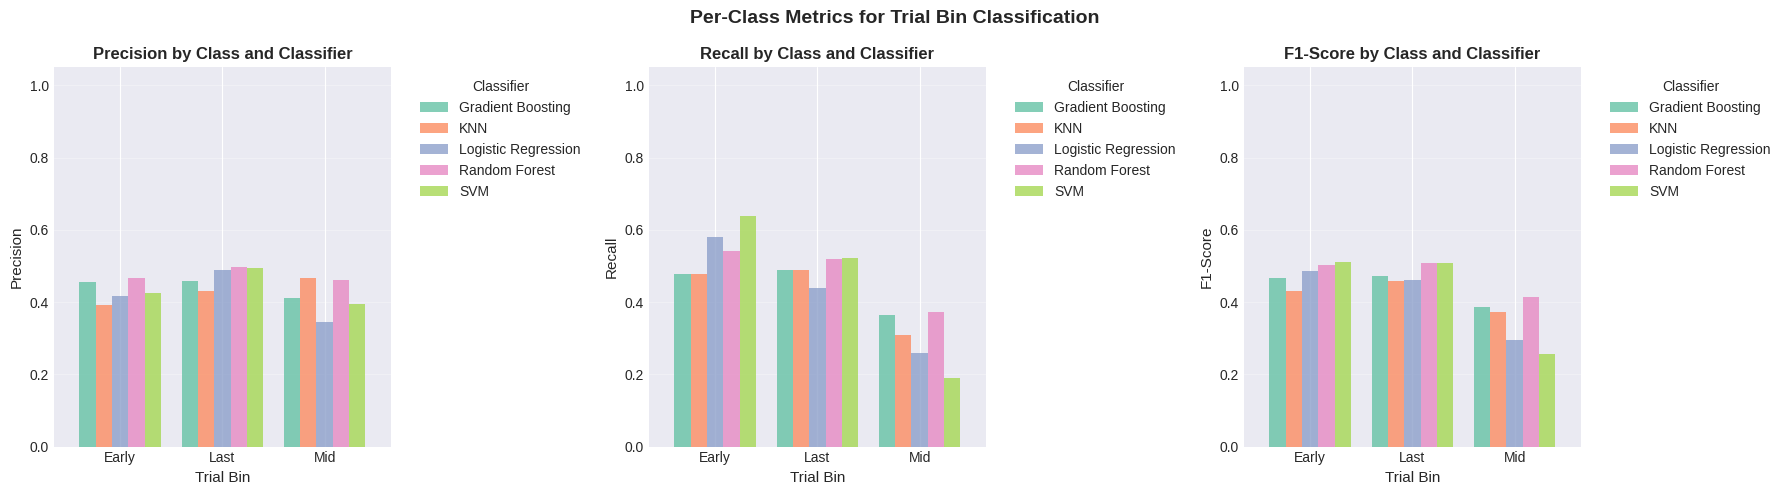

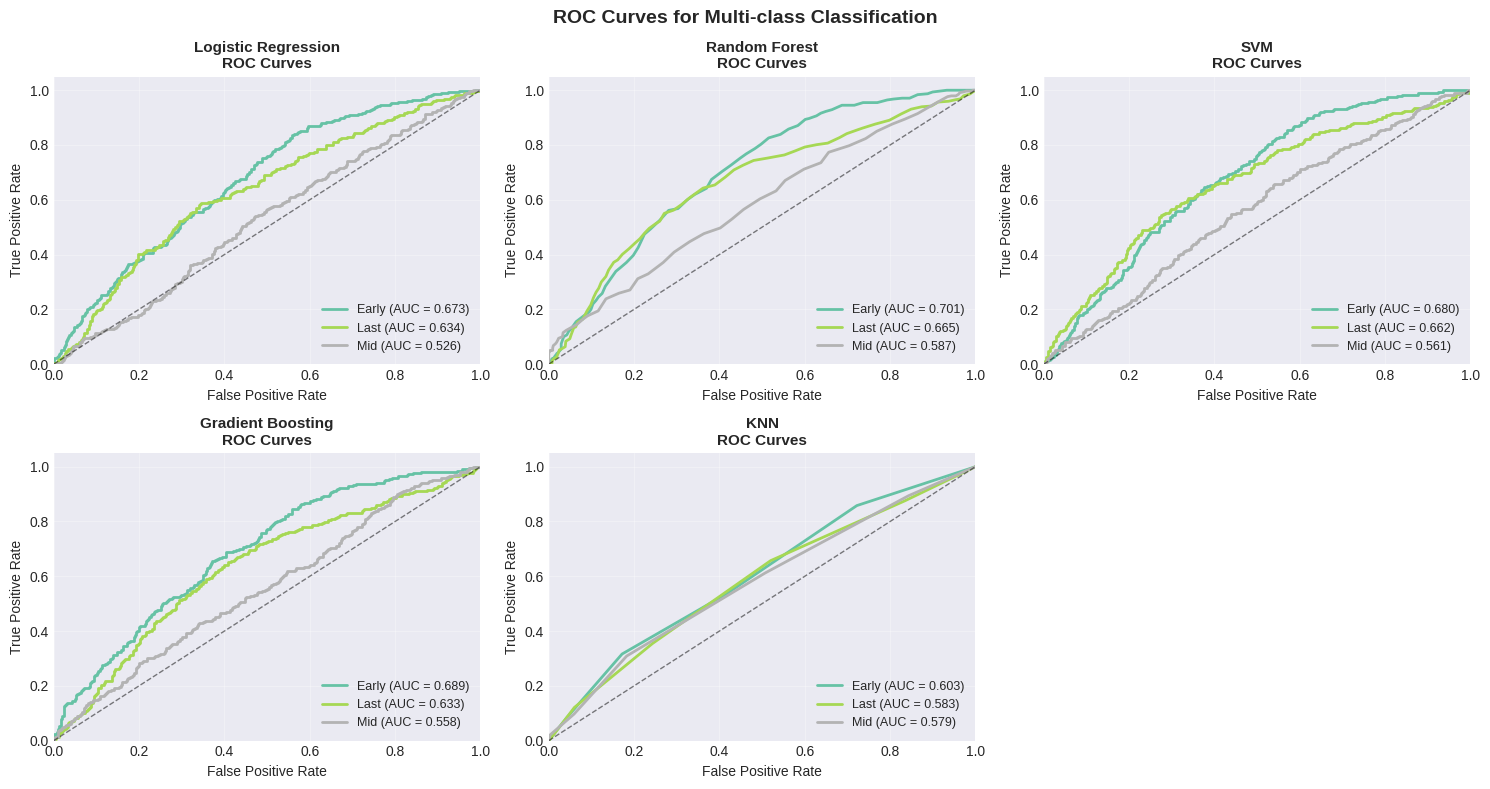

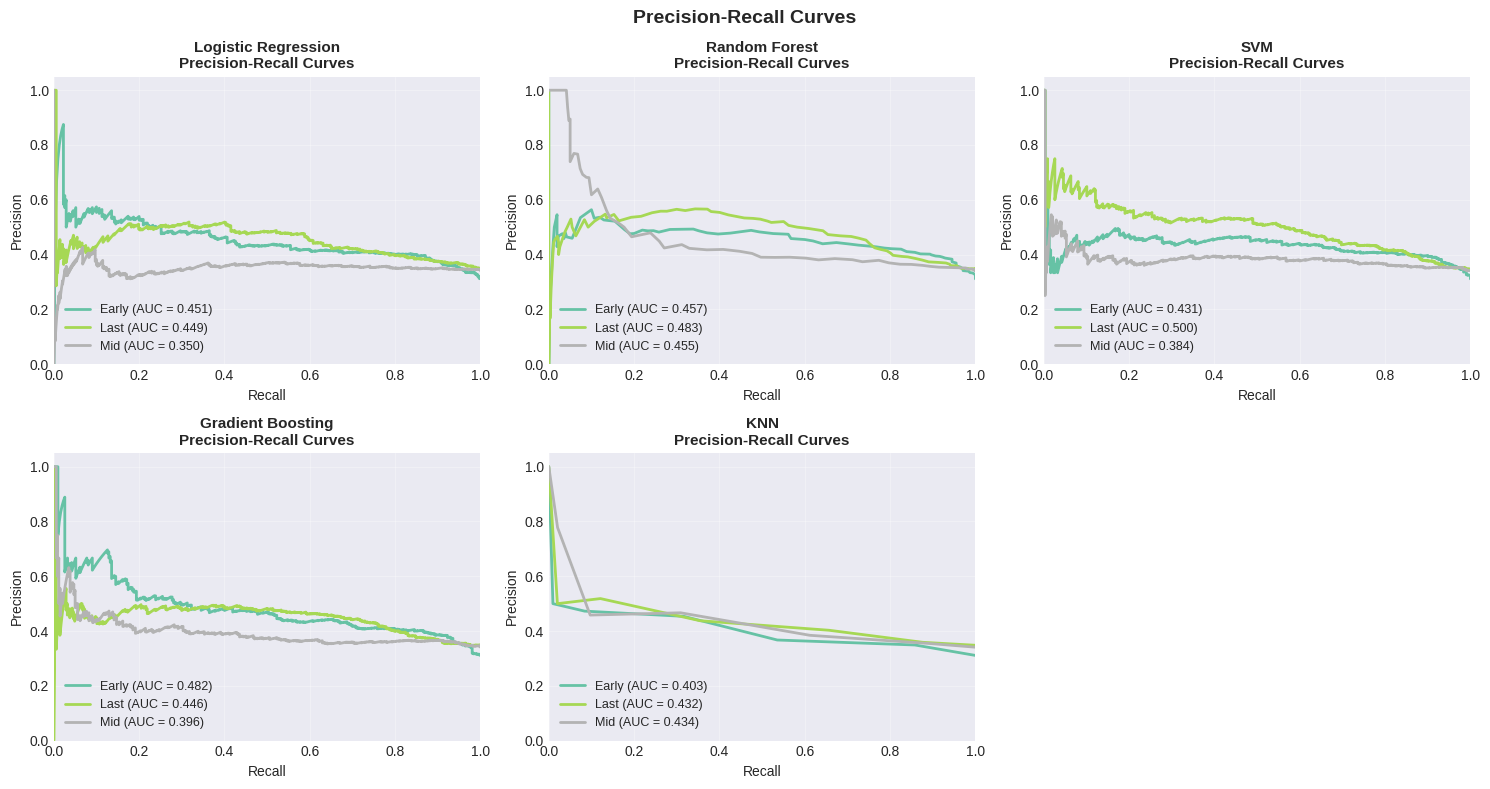

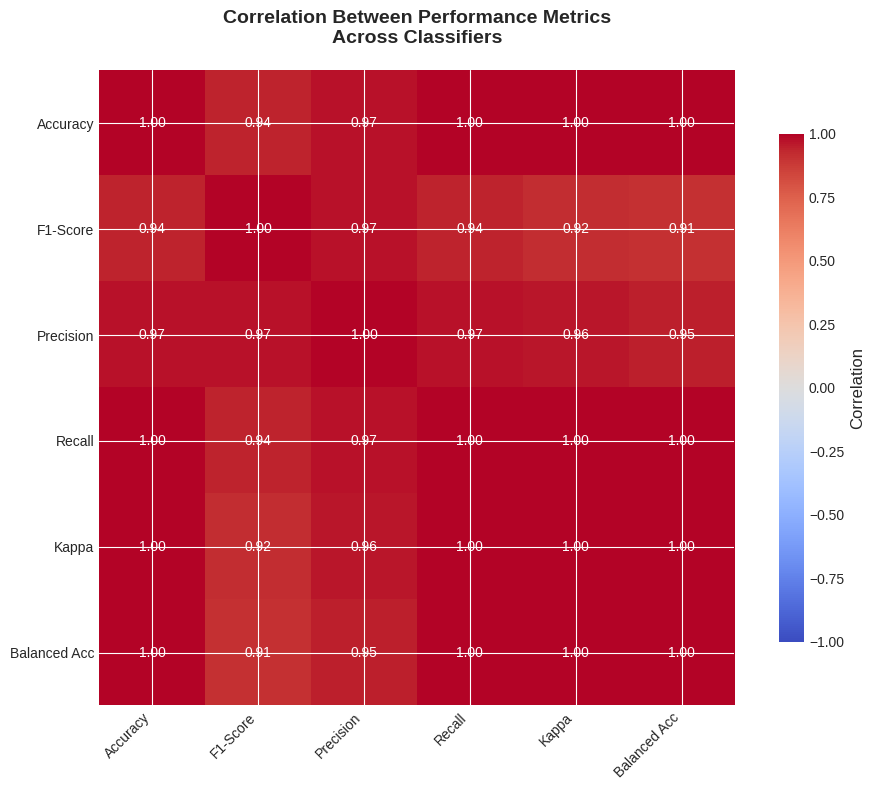

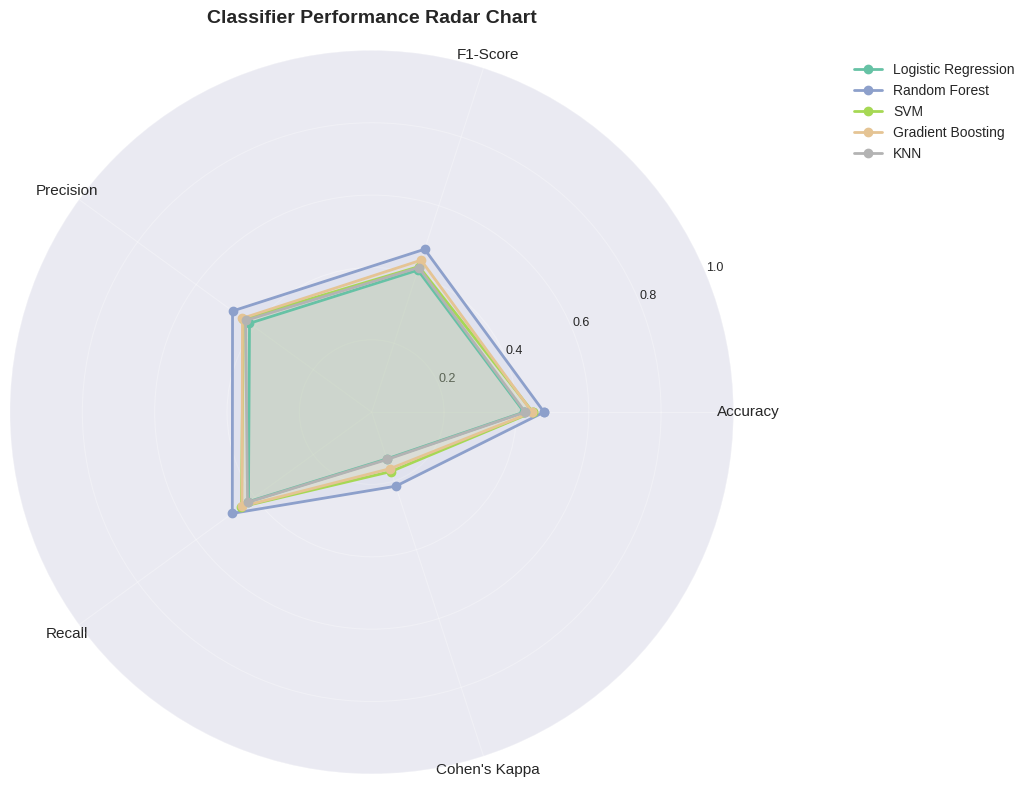


DETAILED PERFORMANCE METRICS

Logistic Regression:
  Accuracy: 0.421
  F1-Score (weighted): 0.413
  F1-Score (macro): 0.415
  Precision (weighted): 0.418
  Recall (weighted): 0.421
  Cohen's Kappa: 0.136
  Balanced Accuracy: 0.426

  Per-class metrics:
    Early: Precision=0.418, Recall=0.581, F1=0.486, Support=310
    Mid: Precision=0.345, Recall=0.259, F1=0.296, Support=340
    Last: Precision=0.489, Recall=0.438, F1=0.462, Support=347

Random Forest:
  Accuracy: 0.476
  F1-Score (weighted): 0.473
  F1-Score (macro): 0.474
  Precision (weighted): 0.476
  Recall (weighted): 0.476
  Cohen's Kappa: 0.215
  Balanced Accuracy: 0.478

  Per-class metrics:
    Early: Precision=0.468, Recall=0.542, F1=0.502, Support=310
    Mid: Precision=0.462, Recall=0.374, F1=0.413, Support=340
    Last: Precision=0.496, Recall=0.519, F1=0.507, Support=347

SVM:
  Accuracy: 0.445
  F1-Score (weighted): 0.423
  F1-Score (macro): 0.425
  Precision (weighted): 0.439
  Recall (weighted): 0.445
  Cohen's Kapp

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                           f1_score, precision_score, recall_score, roc_auc_score,
                           roc_curve, auc, precision_recall_curve, matthews_corrcoef,
                           cohen_kappa_score, balanced_accuracy_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

# Configuration
FS = 250  # Sampling frequency

def prepare_trial_binned_data(signal_df, max_samples=1500):
    """
    Prepare data with trials binned into early, mid, last categories
    """
    print("Preparing binned trial classification data...")

    # Remove stress samples > 7500
    mask = ~((signal_df['sample'] > 7500) & (signal_df['condition'] == 'stress'))
    df = signal_df[mask].copy()

    # Downsample for speed
    def downsample_trial(group, n_samples=max_samples):
        if len(group) > n_samples:
            indices = np.linspace(0, len(group)-1, n_samples, dtype=int)
            return group.iloc[indices]
        return group

    print(f"Downsampling to {max_samples} samples per trial...")
    df_downsampled = []
    for (subject, condition, trial, file), trial_data in df.groupby(['subject', 'condition', 'trial', 'file']):
        df_downsampled.append(downsample_trial(trial_data))
    df = pd.concat(df_downsampled, ignore_index=True)

    # Convert trial numbers to forward order (1=first, 10=last)
    df['trial_forward'] = df.groupby(['subject', 'condition'])['trial'].transform(
        lambda x: x.max() - x + 1
    )

    # Create trial bins: Early (trials 1-3), Mid (4-7), Last (8-10)
    def create_trial_bins(trial_num):
        if trial_num <= 3:
            return 'Last'
        elif trial_num <= 7:
            return 'Mid'
        else:
            return 'Early'

    df['trial_bin'] = df['trial_forward'].apply(create_trial_bins)

    # Check distribution
    bin_dist = df.groupby(['subject', 'condition', 'trial_forward', 'trial_bin']).size().reset_index()
    print("\nTrial bin distribution:")
    print(bin_dist['trial_bin'].value_counts())

    return df

def extract_fast_features(trial_data):
    """
    Fast feature extraction for classification
    """
    cop_x = trial_data['cop_x'].values
    cop_y = trial_data['cop_y'].values

    features = {}

    # Basic statistics
    features.update({
        'x_mean': np.mean(cop_x),
        'x_std': np.std(cop_x),
        'x_range': np.ptp(cop_x),
        'y_mean': np.mean(cop_y),
        'y_std': np.std(cop_y),
        'y_range': np.ptp(cop_y),
        'combined_std': np.std(np.sqrt(cop_x**2 + cop_y**2)),
    })

    # Velocity features
    if len(cop_x) > 1:
        dx = np.diff(cop_x)
        dy = np.diff(cop_y)
        velocity = np.sqrt(dx**2 + dy**2) * FS

        features.update({
            'path_length': np.sum(np.sqrt(dx**2 + dy**2)),
            'v_mean': np.mean(velocity),
            'v_std': np.std(velocity),
            'v_max': np.max(velocity),
            'v_rms': np.sqrt(np.mean(velocity**2)),
        })

    # Frequency features (simplified)
    if len(cop_x) > 10:
        for name, sig in [('x', cop_x), ('y', cop_y)]:
            fft_vals = np.abs(np.fft.rfft(sig))
            if len(fft_vals) > 0:
                features[f'{name}_fft_mean'] = np.mean(fft_vals)
                features[f'{name}_fft_std'] = np.std(fft_vals)
                features[f'{name}_fft_max'] = np.max(fft_vals)

    # Drift features
    if len(cop_x) > 1:
        features.update({
            'drift_x': cop_x[-1] - cop_x[0],
            'drift_y': cop_y[-1] - cop_y[0],
            'total_drift': np.sqrt((cop_x[-1] - cop_x[0])**2 + (cop_y[-1] - cop_y[0])**2),
            'initial_mag': np.sqrt(cop_x[0]**2 + cop_y[0]**2),
            'final_mag': np.sqrt(cop_x[-1]**2 + cop_y[-1]**2),
        })

    return features

class TrialBinClassifier:
    """
    Classifier for early/mid/last trial bins
    """

    def __init__(self, classifiers=None):
        if classifiers is None:
            self.classifiers = {
                'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
                'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
                'SVM': SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'),
                'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
                'KNN': KNeighborsClassifier(n_neighbors=5)
            }
        else:
            self.classifiers = classifiers

        self.feature_names = None
        self.results = None
        self.performance = None

    def extract_features(self, df):
        """Extract features for all trials"""
        features_list = []
        labels = []
        subjects = []
        conditions = []

        print("Extracting features for each trial...")

        trial_groups = list(df.groupby(['subject', 'condition', 'trial_forward', 'file']))

        for idx, ((subject, condition, trial, file), trial_data) in enumerate(trial_groups):
            if idx % 50 == 0:
                print(f"  Processed {idx}/{len(trial_groups)} trials")

            # Get trial bin label
            if trial <= 3:
                label = 'Early'
            elif trial <= 7:
                label = 'Mid'
            else:
                label = 'Last'

            # Extract features
            trial_features = extract_fast_features(trial_data)

            # Store feature names from first trial
            if self.feature_names is None:
                self.feature_names = list(trial_features.keys())

            # Convert to array
            feature_array = np.array([trial_features.get(name, 0) for name in self.feature_names])

            features_list.append(feature_array)
            labels.append(label)
            subjects.append(subject)
            conditions.append(condition)

        X = np.array(features_list)
        y = np.array(labels)
        subjects = np.array(subjects)
        conditions = np.array(conditions)

        print(f"\nExtracted {X.shape[0]} trials with {X.shape[1]} features")
        print(f"Class distribution: {pd.Series(y).value_counts().to_dict()}")

        return X, y, subjects, conditions

    def cross_subject_classification(self, X, y, subjects, n_features=20):
        """Cross-subject validation"""
        unique_subjects = np.unique(subjects)
        results = {name: {'true': [], 'pred': [], 'proba': []} for name in self.classifiers.keys()}

        print(f"\nPerforming {len(unique_subjects)}-fold cross-subject validation...")

        for fold, test_subject in enumerate(unique_subjects, 1):
            print(f"  Fold {fold}/{len(unique_subjects)}: Testing subject {test_subject}")

            # Split data
            train_mask = subjects != test_subject
            test_mask = subjects == test_subject

            X_train, X_test = X[train_mask], X[test_mask]
            y_train, y_test = y[train_mask], y[test_mask]

            if len(np.unique(y_train)) < 2 or len(X_test) == 0:
                continue

            # Scale and select features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            selector = SelectKBest(f_classif, k=min(n_features, X_train.shape[1]))
            X_train_selected = selector.fit_transform(X_train_scaled, y_train)
            X_test_selected = selector.transform(X_test_scaled)

            # Train and evaluate classifiers
            for name, clf in self.classifiers.items():
                clf.fit(X_train_selected, y_train)

                # Predict
                y_pred = clf.predict(X_test_selected)

                # Get probabilities for ROC/AUC
                if hasattr(clf, 'predict_proba'):
                    y_proba = clf.predict_proba(X_test_selected)
                else:
                    y_proba = None

                results[name]['true'].extend(y_test)
                results[name]['pred'].extend(y_pred)
                if y_proba is not None:
                    results[name]['proba'].extend(y_proba)

        self.results = results
        return results

    def evaluate_classifiers(self, results=None):
        """Comprehensive evaluation of classifiers"""
        if results is None:
            results = self.results

        performance = {}
        classes = ['Early', 'Mid', 'Last']  # Define order

        for name, result in results.items():
            y_true = result['true']
            y_pred = result['pred']

            if len(y_true) == 0:
                continue

            # Calculate metrics
            accuracy = accuracy_score(y_true, y_pred)
            f1_weighted = f1_score(y_true, y_pred, average='weighted')
            f1_macro = f1_score(y_true, y_pred, average='macro')
            precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
            recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

            # Additional metrics
            kappa = cohen_kappa_score(y_true, y_pred)
            balanced_acc = balanced_accuracy_score(y_true, y_pred)

            # Per-class metrics
            per_class_metrics = {}
            for cls in classes:
                if cls in y_true:  # Check if class exists in data
                    precision = precision_score(y_true, y_pred, labels=[cls], average='micro', zero_division=0)
                    recall = recall_score(y_true, y_pred, labels=[cls], average='micro', zero_division=0)
                    f1 = f1_score(y_true, y_pred, labels=[cls], average='micro', zero_division=0)
                    per_class_metrics[cls] = {
                        'precision': precision,
                        'recall': recall,
                        'f1': f1,
                        'support': np.sum(np.array(y_true) == cls)
                    }

            performance[name] = {
                'accuracy': accuracy,
                'f1_weighted': f1_weighted,
                'f1_macro': f1_macro,
                'precision_weighted': precision_weighted,
                'recall_weighted': recall_weighted,
                'kappa': kappa,
                'balanced_accuracy': balanced_acc,
                'per_class': per_class_metrics,
                'confusion_matrix': confusion_matrix(y_true, y_pred, labels=classes),
                'n_samples': len(y_true)
            }

        self.performance = performance
        return performance

class PerformanceVisualizer:
    """
    Visualize all classification performance metrics
    """

    def __init__(self, performance, results, classes):
        self.performance = performance
        self.results = results
        self.classes = classes

    def plot_confusion_matrices_grid(self):
        """Plot confusion matrices in a grid"""
        n_classifiers = len(self.performance)
        n_cols = min(3, n_classifiers)
        n_rows = int(np.ceil(n_classifiers / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows * n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        for idx, (name, metrics) in enumerate(self.performance.items()):
            ax = axes[idx] if idx < len(axes) else axes[-1]

            cm = metrics['confusion_matrix']

            # Normalize by row
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)

            # Add text annotations
            thresh = cm_normalized.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    # Show counts and percentages
                    text = f"{cm[i, j]}\n({cm_normalized[i, j]:.1%})"
                    ax.text(j, i, text,
                           ha="center", va="center",
                           color="white" if cm_normalized[i, j] > thresh else "black",
                           fontsize=9)

            ax.set_xlabel('Predicted', fontsize=11)
            ax.set_ylabel('True', fontsize=11)
            ax.set_title(f'{name}\nAcc: {metrics["accuracy"]:.3f}', fontsize=12, fontweight='bold')

            ax.set_xticks(range(len(self.classes)))
            ax.set_yticks(range(len(self.classes)))
            ax.set_xticklabels(self.classes, rotation=45, ha='right')
            ax.set_yticklabels(self.classes)

        # Hide empty subplots
        for idx in range(len(self.performance), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Confusion Matrices - Trial Bin Classification', fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()

    def plot_performance_comparison(self):
        """Compare multiple performance metrics across classifiers"""
        classifiers = list(self.performance.keys())

        # Prepare data for grouped bar plot
        metrics_to_plot = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'kappa']
        metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Cohen\'s Kappa']

        n_metrics = len(metrics_to_plot)
        x = np.arange(len(classifiers))
        width = 0.15

        fig, ax = plt.subplots(figsize=(14, 7))

        for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_names)):
            values = [self.performance[clf][metric] for clf in classifiers]
            offset = (i - n_metrics/2) * width
            bars = ax.bar(x + offset, values, width, label=label, alpha=0.8)

            # Add value labels
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                          xy=(bar.get_x() + bar.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom', fontsize=8)

        ax.set_xlabel('Classifier', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('Classifier Performance Comparison', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(classifiers, rotation=45, ha='right')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.05])

        plt.tight_layout()
        plt.show()

    def plot_per_class_metrics(self):
        """Plot per-class metrics for each classifier"""
        classifiers = list(self.performance.keys())
        classes = self.classes

        # Create subplots for each metric
        metrics = ['precision', 'recall', 'f1']
        metric_names = ['Precision', 'Recall', 'F1-Score']

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for ax, metric, metric_name in zip(axes, metrics, metric_names):
            # Prepare data
            data = []
            for clf in classifiers:
                for cls in classes:
                    if cls in self.performance[clf]['per_class']:
                        value = self.performance[clf]['per_class'][cls][metric]
                        data.append({
                            'Classifier': clf,
                            'Class': cls,
                            'Value': value,
                            'Metric': metric_name
                        })

            df = pd.DataFrame(data)

            # Create grouped bar plot
            if not df.empty:
                pivot_df = df.pivot(index='Class', columns='Classifier', values='Value')
                pivot_df.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)

            ax.set_xlabel('Trial Bin', fontsize=11)
            ax.set_ylabel(metric_name, fontsize=11)
            ax.set_title(f'{metric_name} by Class and Classifier', fontsize=12, fontweight='bold')
            ax.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3, axis='y')
            ax.set_ylim([0, 1.05])
            ax.tick_params(axis='x', rotation=0)

        plt.suptitle('Per-Class Metrics for Trial Bin Classification', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for multi-class classification"""
        classifiers_with_proba = []

        # Find classifiers that support probability estimates
        for name, result in self.results.items():
            if 'proba' in result and len(result['proba']) > 0:
                classifiers_with_proba.append(name)

        if not classifiers_with_proba:
            print("No classifiers with probability estimates available for ROC curves")
            return

        n_classifiers = len(classifiers_with_proba)
        n_cols = min(3, n_classifiers)
        n_rows = int(np.ceil(n_classifiers / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows * n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        # Encode labels for ROC
        le = LabelEncoder()
        all_true = []
        for result in self.results.values():
            all_true.extend(result['true'])
        le.fit(all_true)

        for idx, name in enumerate(classifiers_with_proba):
            if idx >= len(axes):
                break

            ax = axes[idx]
            result = self.results[name]

            if 'proba' not in result or len(result['proba']) == 0:
                continue

            y_true = result['true']
            y_proba = result['proba']

            # Convert to numeric labels
            y_true_encoded = le.transform(y_true)

            # Get unique classes
            classes = le.classes_
            n_classes = len(classes)

            # Plot ROC curve for each class (one-vs-rest)
            colors = plt.cm.Set2(np.linspace(0, 1, n_classes))

            for i, (cls, color) in enumerate(zip(classes, colors)):
                # Binarize the labels for this class
                y_true_binary = (y_true_encoded == i).astype(int)
                y_score = [p[i] for p in y_proba]

                fpr, tpr, _ = roc_curve(y_true_binary, y_score)
                roc_auc = auc(fpr, tpr)

                ax.plot(fpr, tpr, color=color, lw=2,
                       label=f'{cls} (AUC = {roc_auc:.3f})')

            ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate', fontsize=10)
            ax.set_ylabel('True Positive Rate', fontsize=10)
            ax.set_title(f'{name}\nROC Curves', fontsize=11, fontweight='bold')
            ax.legend(loc='lower right', fontsize=9)
            ax.grid(True, alpha=0.3)

        # Hide empty subplots
        for idx in range(len(classifiers_with_proba), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('ROC Curves for Multi-class Classification', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_precision_recall_curves(self):
        """Plot precision-recall curves"""
        classifiers_with_proba = []

        for name, result in self.results.items():
            if 'proba' in result and len(result['proba']) > 0:
                classifiers_with_proba.append(name)

        if not classifiers_with_proba:
            return

        n_classifiers = len(classifiers_with_proba)
        n_cols = min(3, n_classifiers)
        n_rows = int(np.ceil(n_classifiers / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_rows * n_cols > 1:
            axes = axes.flatten()
        else:
            axes = [axes]

        le = LabelEncoder()
        all_true = []
        for result in self.results.values():
            all_true.extend(result['true'])
        le.fit(all_true)

        for idx, name in enumerate(classifiers_with_proba):
            if idx >= len(axes):
                break

            ax = axes[idx]
            result = self.results[name]

            y_true = result['true']
            y_proba = result['proba']
            y_true_encoded = le.transform(y_true)
            classes = le.classes_

            colors = plt.cm.Set2(np.linspace(0, 1, len(classes)))

            for i, (cls, color) in enumerate(zip(classes, colors)):
                y_true_binary = (y_true_encoded == i).astype(int)
                y_score = [p[i] for p in y_proba]

                precision, recall, _ = precision_recall_curve(y_true_binary, y_score)
                pr_auc = auc(recall, precision)

                ax.plot(recall, precision, color=color, lw=2,
                       label=f'{cls} (AUC = {pr_auc:.3f})')

            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('Recall', fontsize=10)
            ax.set_ylabel('Precision', fontsize=10)
            ax.set_title(f'{name}\nPrecision-Recall Curves', fontsize=11, fontweight='bold')
            ax.legend(loc='lower left', fontsize=9)
            ax.grid(True, alpha=0.3)

        for idx in range(len(classifiers_with_proba), len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Precision-Recall Curves', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

    def plot_correlation_heatmap(self):
        """Plot correlation heatmap of performance metrics"""
        classifiers = list(self.performance.keys())

        # Create correlation matrix of metrics across classifiers
        metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'kappa', 'balanced_accuracy']
        metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Kappa', 'Balanced Acc']

        corr_matrix = np.zeros((len(metrics), len(metrics)))

        for i in range(len(metrics)):
            for j in range(len(metrics)):
                if i == j:
                    corr_matrix[i, j] = 1.0
                else:
                    # Calculate correlation across classifiers
                    values_i = [self.performance[clf][metrics[i]] for clf in classifiers]
                    values_j = [self.performance[clf][metrics[j]] for clf in classifiers]
                    corr_matrix[i, j] = np.corrcoef(values_i, values_j)[0, 1]

        fig, ax = plt.subplots(figsize=(10, 8))
        im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
        cbar.set_label('Correlation', fontsize=12)

        # Set labels
        ax.set_xticks(np.arange(len(metrics)))
        ax.set_yticks(np.arange(len(metrics)))
        ax.set_xticklabels(metric_names, rotation=45, ha='right')
        ax.set_yticklabels(metric_names)

        # Add text annotations
        for i in range(len(metrics)):
            for j in range(len(metrics)):
                text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                             ha="center", va="center",
                             color="white" if abs(corr_matrix[i, j]) > 0.5 else "black",
                             fontsize=10)

        ax.set_title('Correlation Between Performance Metrics\nAcross Classifiers',
                    fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    def plot_radar_chart(self):
        """Plot radar chart of classifier performance"""
        classifiers = list(self.performance.keys())

        # Select key metrics for radar chart
        metrics = ['accuracy', 'f1_weighted', 'precision_weighted', 'recall_weighted', 'kappa']
        metric_names = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'Cohen\'s Kappa']

        # Prepare data
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Close the circle

        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

        colors = plt.cm.Set2(np.linspace(0, 1, len(classifiers)))

        for idx, (clf, color) in enumerate(zip(classifiers, colors)):
            values = [self.performance[clf][metric] for metric in metrics]
            values += values[:1]  # Close the circle

            ax.plot(angles, values, 'o-', linewidth=2, label=clf, color=color)
            ax.fill(angles, values, alpha=0.1, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metric_names, fontsize=11)
        ax.set_ylim([0, 1.0])
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
        ax.grid(True, alpha=0.3)

        ax.set_title('Classifier Performance Radar Chart', fontsize=14, fontweight='bold', pad=20)
        ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_all_statistics(self):
        """Generate all performance plots"""
        print("\nGenerating comprehensive performance visualizations...")

        self.plot_confusion_matrices_grid()
        self.plot_performance_comparison()
        self.plot_per_class_metrics()
        self.plot_roc_curves()
        self.plot_precision_recall_curves()
        self.plot_correlation_heatmap()
        self.plot_radar_chart()

def run_trial_bin_classification_pipeline(signal_df):
    """
    Main pipeline for trial bin classification
    """
    print("="*70)
    print("TRIAL BIN CLASSIFICATION PIPELINE")
    print("="*70)
    print("Bins: Early (trials 1-3), Mid (4-7), Last (8-10)")
    print("="*70)

    import time
    start_time = time.time()

    # Step 1: Prepare data with trial bins
    df = prepare_trial_binned_data(signal_df, max_samples=1500)

    # Step 2: Initialize classifier
    classifier = TrialBinClassifier()

    # Step 3: Extract features
    X, y, subjects, conditions = classifier.extract_features(df)

    # Step 4: Cross-subject classification
    results = classifier.cross_subject_classification(X, y, subjects, n_features=25)

    # Step 5: Evaluate classifiers
    performance = classifier.evaluate_classifiers(results)

    # Step 6: Visualize results
    classes = ['Early', 'Mid', 'Last']
    visualizer = PerformanceVisualizer(performance, results, classes)
    visualizer.plot_all_statistics()

    # Print detailed results
    print("\n" + "="*70)
    print("DETAILED PERFORMANCE METRICS")
    print("="*70)

    for name, metrics in performance.items():
        print(f"\n{name}:")
        print(f"  Accuracy: {metrics['accuracy']:.3f}")
        print(f"  F1-Score (weighted): {metrics['f1_weighted']:.3f}")
        print(f"  F1-Score (macro): {metrics['f1_macro']:.3f}")
        print(f"  Precision (weighted): {metrics['precision_weighted']:.3f}")
        print(f"  Recall (weighted): {metrics['recall_weighted']:.3f}")
        print(f"  Cohen's Kappa: {metrics['kappa']:.3f}")
        print(f"  Balanced Accuracy: {metrics['balanced_accuracy']:.3f}")

        print("\n  Per-class metrics:")
        for cls in classes:
            if cls in metrics['per_class']:
                cls_metrics = metrics['per_class'][cls]
                print(f"    {cls}: Precision={cls_metrics['precision']:.3f}, "
                      f"Recall={cls_metrics['recall']:.3f}, F1={cls_metrics['f1']:.3f}, "
                      f"Support={cls_metrics['support']}")

    # Summary table
    print("\n" + "="*70)
    print("SUMMARY TABLE (sorted by Accuracy)")
    print("="*70)

    sorted_perf = sorted(performance.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    print(f"\n{'Classifier':<25} {'Accuracy':<10} {'F1-Score':<10} {'Kappa':<10} {'Balanced Acc':<12}")
    print("-"*70)

    for name, metrics in sorted_perf:
        print(f"{name:<25} {metrics['accuracy']:<10.3f} {metrics['f1_weighted']:<10.3f} "
              f"{metrics['kappa']:<10.3f} {metrics['balanced_accuracy']:<12.3f}")

    # Research interpretation
    print("\n" + "="*70)
    print("RESEARCH INTERPRETATION")
    print("="*70)

    best_clf, best_metrics = sorted_perf[0]
    chance_level = 1 / 3  # 3 classes

    print(f"\nBest classifier: {best_clf}")
    print(f"Accuracy: {best_metrics['accuracy']:.3f} (Chance: {chance_level:.3f})")
    print(f"Cohen's Kappa: {best_metrics['kappa']:.3f}")

    # Kappa interpretation
    kappa = best_metrics['kappa']
    if kappa > 0.8:
        print("✓ Excellent agreement beyond chance")
        print("  Strong evidence for distinct COP patterns in each trial phase")
    elif kappa > 0.6:
        print("○ Substantial agreement beyond chance")
        print("  Good evidence for systematic differences across trial phases")
    elif kappa > 0.4:
        print("○ Moderate agreement beyond chance")
        print("  Some evidence for phase-dependent COP patterns")
    elif kappa > 0.2:
        print("○ Fair agreement beyond chance")
        print("  Weak evidence for trial phase differences")
    else:
        print("× Poor agreement with chance")
        print("  Little evidence for distinct COP patterns across phases")

    # Class-specific insights
    print("\nClass-specific performance insights:")
    for cls in classes:
        if cls in best_metrics['per_class']:
            metrics = best_metrics['per_class'][cls]
            print(f"  {cls} trials: Precision={metrics['precision']:.3f}, "
                  f"Recall={metrics['recall']:.3f}")

            if metrics['precision'] > 0.7 and metrics['recall'] > 0.7:
                print(f"    ✓ {cls} trials are well-predicted")
            elif metrics['precision'] > 0.5 or metrics['recall'] > 0.5:
                print(f"    ○ Moderate prediction for {cls} trials")
            else:
                print(f"    × {cls} trials are difficult to predict")

    total_time = time.time() - start_time
    print(f"\nTotal processing time: {total_time:.1f}s ({total_time/60:.1f} minutes)")

    return {
        'classifier': classifier,
        'performance': performance,
        'results': results,
        'visualizer': visualizer,
        'X': X,
        'y': y,
        'subjects': subjects,
        'classes': classes
    }

# Example usage
if __name__ == "__main__":




    print(f"\nSample data created: {len(signal_df)} rows")
    print(f"Subjects: {n_subjects}, Trials per subject: {n_trials*2}")

    # Run the pipeline
    results = run_trial_bin_classification_pipeline(signal_df)